In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Web Scraping for Indeed.com and Predicting Salaries

Analyze data from Indeed.com to discover the most important predictors for salary amounts in various data related fields.

**Goal:** 
* Scrape data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.
* Discover which job features impact salary the most
* Create a classification model to predict if a job will pay over or under median salary based on the features of the job


## Scraping job listings from Indeed.com

In [1]:
url_1 = "https://www.indeed.co.uk/jobs?q=Data+Scientist+%C2%A320%2C000&l=London%2C+Greater+London"

In [9]:
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
r_1 = requests.get(url_1)
soup_1 = BeautifulSoup(r_1.text, 'html.parser')

### Create functions to extract different elements of the job postings (Location, job title, company, salary, description, company rating)

In [3]:
#input for functions is the soup defined by the link 

def extract_location_from_result(result):
    location = []
    for role in result.find_all('div', attrs={'class':'result'}): 
        try: 
            try:
                location.append(role.find('span', attrs={'class': 'location accessible-contrast-color-location'}).text)
            except:
                location.append(role.find('div', attrs={'class': 'location accessible-contrast-color-location'}).text)
        except:
            location.append(np.nan)
                
    return location
        
def extract_job_from_result(result):
    job = []
    for role in result.find_all('div', attrs={'class':'result'}): 
        try:
            job.append(role.find('div', attrs={'class':'title'}).text.strip()) 
        except:
            job.append(np.nan)
    return job

def extract_company_from_result(result):
    company = []
    for role in result.find_all('div', attrs={'class':'result'}): 
        try:
            company.append(role.find('span', attrs={'class':'company'}).text.strip())
        except:
            company.append(np.nan)
    return company
            
def extract_salary_from_result(result):
    salary = []
    for role in result.find_all('div', attrs={'class':'result'}): 
        try:
            salary.append(role.find('span', attrs={'class':'salaryText'}).text.strip())
        except:
            salary.append(np.nan)
    return salary
    
def extract_desc_from_result(result):
    description = []
    for role in result.find_all('div', attrs={'class':'result'}):    
        try:
            description.append(role.find('div', attrs={'class':'summary'}).text.replace('\n', ''))
        except:
            description.append(np.nan)
    return description

def extract_rating_from_result(result):
    rating = []
    for role in result.find_all('div', attrs={'class':'result'}):    
        try:
            rating.append(role.find('span', attrs={'class':'ratingsContent'}).text.replace('\n', ''))
        except:
            rating.append(np.nan)
    return rating

In [49]:
#print first page of London results in data frame

url_1 = "https://www.indeed.co.uk/jobs?q=Data+Scientist+%C2%A320%2C000&l=London%2C+Greater+London"
r_1 = requests.get(url_1)
soup_1 = BeautifulSoup(r.text, 'html.parser')

open_roles = pd.DataFrame({'Location': extract_location_from_result(soup_1), 'Company': extract_company_from_result(soup_1), 
                           'Job': extract_job_from_result(soup_1), 'Salary': extract_salary_from_result(soup_1), 'Description': extract_desc_from_result(soup_1)})

open_roles

,Location,Company,Job,Salary,Description
0,London,HealthyHealth,Data Scientist,NaN,"We collect on average 600,000 data points annu..."
1,London,UK Government - Department for Work and Pensions,Data Scientist,"£35,754 - £50,938 a year",The Department as a whole is undergoing a majo...
2,London,G-Research,Data Scientist,NaN,This capability allows us to adapt to the dema...
3,London,Buzz Radar,Data Scientist Intern,NaN,You’ll help support the Buzz Radar product roa...
4,London,Heineken,Data Scientist Job,NaN,Salary: £competitive + Bonus + 35 days holiday...
5,London,Michael Page UK,Junior Data Scientist,"£32,000 - £40,000 a year","Data Analysis, Data Science, Graduate Analyst...."
6,London,DXC,Data Scientist,NaN,Data Scientist scope can range from ad-hoc ana...
7,London EC2A,Seldon,Data Scientist,NaN,We are looking for a Data Scientist to join ou...
8,London,Entia,Data Scientist,NaN,We have sky-high ambitions and a pretty exciti...
9,London,MasterCard,Junior Data Scientist,NaN,Within the research team you will help build s...


In [51]:
#checking code with another city link

url_2 = 'https://www.indeed.co.uk/jobs?q=Data+Scientist+%C2%A320%2C000&l=Manchester%2C+Greater+Manchester'

r_2 = requests.get(url_2)
soup_2 = BeautifulSoup(r_2.text, 'html.parser')

open_roles_2 = pd.DataFrame({'Location': extract_location_from_result(soup_2), 'Company': extract_company_from_result(soup_2), 
                           'Job': extract_job_from_result(soup_2), 'Salary': extract_salary_from_result(soup_2), 'Description': extract_desc_from_result(soup_2)})

open_roles_2

,Location,Company,Job,Salary,Description
0,Manchester,Veea Group,Data Science Graduate Scheme,"£30,000 a year",You will be tasked with turning huge amounts o...
1,Salford M5,MWH Treatment,Graduate Data Scientist - Salford Quays,NaN,We have an opportunity based from the Head off...
2,Manchester,Interactive Selection,Data Scientist,NaN,Analyse player data to proactively identify an...
3,Manchester,Aspire Data Recruitment,Research Scientist – Research & Applied Data S...,"£45,000 - £55,000 a year",Research Scientist – Research & Applied Data S...
4,Manchester,Hasson Associates,"Junior Marketing & Data Scientist – Big Data, ...","£25,000 - £32,000 a year",This forward-thinking boutique data science an...
5,Manchester,Venturi,Data Scientist,"£40,000 - £50,000 a year","Data Scientist ( R / Python / SQL ), Up to £55..."
6,Oldham OL9,MBN Solutions,Data Scientist,"£55,000 a year","Up to £55,000 + Extensive Benefits .Benefits i..."
7,Wilmslow,Warner Bros. Entertainment Group,Data Scientist,NaN,Analyse player data to proactively identify an...
8,Manchester,Booking.com,Insight Data Scientist,NaN,And they’re always ready for change.As Booking...
9,Bolton,Dynamix Recruitment Ltd,Data Scientist,"£60,000 - £70,000 a year",As a senior data scientist within the exciting...


### Extend the code to collect results from multiple cities and iterate through all pages of job listings. 

#### London

In [144]:
# start by collecting all results from London

london_company = []
london_job = []
london_desc = []
london_salary = []

for x in tqdm(range(10, 8000, 10)):
    url_template = 'https://www.indeed.co.uk/jobs?q=%22Data+Scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22++%C2%A320,000&l=London&start={}'.format(x)
    r = requests.get(url_template)
    soup = BeautifulSoup(r.text, 'html.parser')
    london_company.append(extract_company_from_result(soup))
    london_job.append(extract_job_from_result(soup))
    london_desc.append(extract_desc_from_result(soup))
    london_salary.append(extract_salary_from_result(soup))
  
 #flatten lists of lists that were created
london_company_flat = [item for sublist in london_company for item in sublist]
london_job_flat = [item for sublist in london_job for item in sublist]
london_desc_flat = [item for sublist in london_desc for item in sublist]
london_salary_flat = [item for sublist in london_salary for item in sublist]
    
london_roles = pd.DataFrame({'Company': london_company_flat, 
                           'Job': london_job_flat, 'Salary': london_salary_flat, 'Description': london_desc_flat})

london_roles.head()








  0%|          | 0/999 [00:00<?, ?it/s]






  0%|          | 1/999 [00:00<13:27,  1.24it/s]






  0%|          | 2/999 [00:02<17:13,  1.04s/it]






  0%|          | 3/999 [00:03<18:53,  1.14s/it]






  0%|          | 4/999 [00:05<19:28,  1.17s/it]






  1%|          | 5/999 [00:07<27:55,  1.69s/it]






  1%|          | 6/999 [00:09<27:50,  1.68s/it]






  1%|          | 7/999 [00:10<26:18,  1.59s/it]






  1%|          | 8/999 [00:12<27:55,  1.69s/it]






  1%|          | 9/999 [00:14<25:52,  1.57s/it]






  1%|          | 10/999 [00:15<24:08,  1.46s/it]






  1%|          | 11/999 [00:16<23:35,  1.43s/it]






  1%|          | 12/999 [00:18<22:54,  1.39s/it]






  1%|▏         | 13/999 [00:19<22:55,  1.40s/it]






  1%|▏         | 14/999 [00:20<20:28,  1.25s/it]






  2%|▏         | 15/999 [00:21<20:30,  1.25s/it]






  2%|▏         | 16/999 [00:23<22:20,  1.36s/it]






  2%|▏         | 17/999 [00:24<20:50,  1.27s/it]






  2%|▏         | 18/9

KeyboardInterrupt: 

In [137]:
london_roles.shape

(14658, 4)

In [138]:
#add London as the location for each listing

london_roles['Location'] = 'London'

In [139]:
#delete duplicates 

london_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

In [140]:
london_roles.shape

(931, 5)

##### Clean Salary Column

In [141]:
#remove any rows that do not contain a salary
london_roles_na = london_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
london_roles_new = london_roles_na[~london_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_london_salary = []
for row in london_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('£', '')
    new_london_salary.append(row.replace(',', '').strip())

In [142]:
#if a salary range is given, return the average 
#if one value is given for salary return that value
#all salaries should be an integer

x_london = []
for row in new_london_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_london.append(int(average))
    else:
        x_london.append(int(row))


london_roles_new['Salary'] = x_london

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [143]:
london_roles_new.shape

(346, 5)

#####  Save to CSV

In [145]:
london_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_london.csv', header = london_roles_new.columns, index=False)

#### Other UK cities. 
It was better to seporate these from London because these cities have much fewer pages of listings, so the number of iterations had to be lower so that I didn't overscrape.

In [188]:
UK = ['Edinburgh', 'Essex', 'Bath', 'Cambridge', 'Brighton', 'Glasgow', 'Cardiff', 'Liverpool', 'Oxford', 'Cambridge', 'Bristol', 'Manchester']

uk_company = []
uk_job = []
uk_desc = []
uk_salary = []
uk_location = []

for city in UK:
    for x in tqdm(range(0, 150, 10)):
        url_template = 'https://www.indeed.co.uk/jobs?q=%22Data+Scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22++%C2%A320,000&l={}&start={}'.format(city, x)
        r = requests.get(url_template)
        soup = BeautifulSoup(r.text, 'html.parser')
        uk_company.append(extract_company_from_result(soup))
        uk_job.append(extract_job_from_result(soup))
        uk_desc.append(extract_desc_from_result(soup))
        uk_salary.append(extract_salary_from_result(soup))
        uk_location.append((city + ' ')* len(extract_company_from_result(soup)))
  
uk_loc_new = [string.rstrip().split(' ') for string in uk_location]

#flatten lists of lists that were created
uk_company_flat = [item for sublist in uk_company for item in sublist]
uk_job_flat = [item for sublist in uk_job for item in sublist]
uk_desc_flat = [item for sublist in uk_desc for item in sublist]
uk_salary_flat = [item for sublist in uk_salary for item in sublist]
uk_loc_flat = [item for sublist in uk_loc_new for item in sublist]
    
uk_roles = pd.DataFrame({'Company': uk_company_flat, 'Location': uk_loc_flat,
                           'Job': uk_job_flat, 'Salary': uk_salary_flat, 'Description': uk_desc_flat})

                
uk_roles.head()











  0%|          | 0/15 [00:00<?, ?it/s]








  7%|▋         | 1/15 [00:00<00:08,  1.67it/s]








 13%|█▎        | 2/15 [00:01<00:08,  1.50it/s]








 20%|██        | 3/15 [00:01<00:07,  1.58it/s]








 27%|██▋       | 4/15 [00:02<00:06,  1.68it/s]








 33%|███▎      | 5/15 [00:03<00:05,  1.73it/s]








 40%|████      | 6/15 [00:03<00:05,  1.73it/s]








 47%|████▋     | 7/15 [00:04<00:04,  1.77it/s]








 53%|█████▎    | 8/15 [00:04<00:03,  1.79it/s]








 60%|██████    | 9/15 [00:05<00:03,  1.80it/s]








 67%|██████▋   | 10/15 [00:05<00:02,  1.81it/s]








 73%|███████▎  | 11/15 [00:06<00:02,  1.78it/s]








 80%|████████  | 12/15 [00:06<00:01,  1.74it/s]








 87%|████████▋ | 13/15 [00:07<00:01,  1.77it/s]








 93%|█████████▎| 14/15 [00:08<00:00,  1.74it/s]








100%|██████████| 15/15 [00:08<00:00,  1.71it/s]









  0%|          | 0/15 [00:00<?, ?it/s]








  7%|▋         | 1/15 [00:00<00:07,  1.90it/s]








 13%|█▎   

 27%|██▋       | 4/15 [00:02<00:07,  1.52it/s]








 33%|███▎      | 5/15 [00:03<00:06,  1.56it/s]








 40%|████      | 6/15 [00:03<00:05,  1.57it/s]








 47%|████▋     | 7/15 [00:04<00:05,  1.57it/s]








 53%|█████▎    | 8/15 [00:05<00:04,  1.56it/s]








 60%|██████    | 9/15 [00:05<00:03,  1.54it/s]








 67%|██████▋   | 10/15 [00:06<00:03,  1.53it/s]








 73%|███████▎  | 11/15 [00:07<00:02,  1.52it/s]








 80%|████████  | 12/15 [00:07<00:02,  1.42it/s]








 87%|████████▋ | 13/15 [00:08<00:01,  1.41it/s]








 93%|█████████▎| 14/15 [00:09<00:00,  1.43it/s]








100%|██████████| 15/15 [00:09<00:00,  1.50it/s]









  0%|          | 0/15 [00:00<?, ?it/s]








  7%|▋         | 1/15 [00:00<00:09,  1.54it/s]








 13%|█▎        | 2/15 [00:01<00:08,  1.60it/s]








 20%|██        | 3/15 [00:01<00:07,  1.61it/s]








 27%|██▋       | 4/15 [00:02<00:06,  1.59it/s]








 33%|███▎      | 5/15 [00:03<00:06,  1.60it/s]








 40%|████  

,Company,Location,Job,Salary,Description
0,experisuk,Edinburgh,Data Scientist,NaN,I am currently looking for talented Data Scien...
1,Pandora,Edinburgh,"Data Analyst, Global Data & Insights - Assiste...",NaN,Experience with turning data into insights and...
2,MBN Solutions,Edinburgh,Junior Data Analyst,"£25,000 a year",You should be a competent user of SQL (Oracle ...
3,Merkle Periscopix,Edinburgh,Junior Marketing Data Analyst Role (Edinburgh ...,NaN,Analyse media data to build data-driven attrib...
4,The Green Recruitment Company,Edinburgh,Data Scientist- Wind,NaN,"The organization is keen to get intelligent, h..."


In [189]:
uk_roles.shape

(2283, 5)

In [190]:
#delete duplicates 

uk_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

##### Clean Salary Column

In [191]:
#remove any rows that do not contain a salary
uk_roles_na = uk_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
uk_roles_new = uk_roles_na[~uk_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_uk_salary = []
for row in uk_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('£', '')
    new_uk_salary.append(row.replace(',', '').strip())

In [489]:
#if a salary range is give, return the average 
#if one value is given for salary return that value
#all salaries should be an integer

x_uk = []
for row in new_uk_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_uk.append(int(average))
    else:
        x_uk.append(int(row))


uk_roles_new['Salary'] = x_uk

NameError: name 'new_uk_salary' is not defined

In [193]:
uk_roles_new.shape

(152, 5)

##### Save to CSV



In [194]:
uk_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_uk.csv', header = uk_roles_new.columns, index=False)

#### New York City 

In [197]:
nyc_company = []
nyc_job = []
nyc_desc = []
nyc_salary = []

for x in tqdm(range(0, 8000, 10)):
    url_template = 'https://www.indeed.com/jobs?q=%22data+scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22+%2425%2C000&l=New+York+City&start={}'.format(x)
    r = requests.get(url_template)
    soup = BeautifulSoup(r.text, 'html.parser')
    nyc_company.append(extract_company_from_result(soup))
    nyc_job.append(extract_job_from_result(soup))
    nyc_desc.append(extract_desc_from_result(soup))
    nyc_salary.append(extract_salary_from_result(soup))
    
    
#flatten lists of lists that were created
nyc_company_flat = [item for sublist in nyc_company for item in sublist]
nyc_job_flat = [item for sublist in nyc_job for item in sublist]
nyc_desc_flat = [item for sublist in nyc_desc for item in sublist]
nyc_salary_flat = [item for sublist in nyc_salary for item in sublist]


nyc_roles = pd.DataFrame({'Company': nyc_company_flat, 
                           'Job': nyc_job_flat, 'Salary': nyc_salary_flat, 'Description': nyc_desc_flat})
nyc_roles.head()











  0%|          | 0/800 [00:00<?, ?it/s]









  0%|          | 1/800 [00:01<17:51,  1.34s/it]









  0%|          | 2/800 [00:02<17:26,  1.31s/it]









  0%|          | 3/800 [00:03<16:48,  1.27s/it]









  0%|          | 4/800 [00:05<16:47,  1.27s/it]









  1%|          | 5/800 [00:06<16:23,  1.24s/it]









  1%|          | 6/800 [00:07<16:54,  1.28s/it]









  1%|          | 7/800 [00:08<17:09,  1.30s/it]









  1%|          | 8/800 [00:10<16:37,  1.26s/it]









  1%|          | 9/800 [00:11<16:19,  1.24s/it]









  1%|▏         | 10/800 [00:12<16:08,  1.23s/it]









  1%|▏         | 11/800 [00:13<16:07,  1.23s/it]









  2%|▏         | 12/800 [00:14<16:16,  1.24s/it]









  2%|▏         | 13/800 [00:16<15:55,  1.21s/it]









  2%|▏         | 14/800 [00:17<15:47,  1.21s/it]









  2%|▏         | 15/800 [00:18<15:49,  1.21s/it]









  2%|▏         | 16/800 [00:19<15:47,  1.21s/it]









  2%|▏         | 17/80

 23%|██▎       | 185/800 [04:30<13:52,  1.35s/it]









 23%|██▎       | 186/800 [04:31<14:17,  1.40s/it]









 23%|██▎       | 187/800 [04:32<13:33,  1.33s/it]









 24%|██▎       | 188/800 [04:34<13:12,  1.30s/it]









 24%|██▎       | 189/800 [04:35<12:44,  1.25s/it]









 24%|██▍       | 190/800 [04:36<12:32,  1.23s/it]









 24%|██▍       | 191/800 [04:37<12:19,  1.21s/it]









 24%|██▍       | 192/800 [04:38<12:29,  1.23s/it]









 24%|██▍       | 193/800 [04:40<12:28,  1.23s/it]









 24%|██▍       | 194/800 [04:41<12:11,  1.21s/it]









 24%|██▍       | 195/800 [04:42<11:58,  1.19s/it]









 24%|██▍       | 196/800 [04:43<11:56,  1.19s/it]









 25%|██▍       | 197/800 [04:44<11:50,  1.18s/it]









 25%|██▍       | 198/800 [04:45<12:03,  1.20s/it]









 25%|██▍       | 199/800 [04:47<11:56,  1.19s/it]









 25%|██▌       | 200/800 [04:48<11:52,  1.19s/it]









 25%|██▌       | 201/800 [04:49<12:33,  1.26s/it]








 46%|████▌     | 369/800 [09:59<17:02,  2.37s/it]









 46%|████▋     | 370/800 [10:02<16:37,  2.32s/it]









 46%|████▋     | 371/800 [10:03<15:18,  2.14s/it]









 46%|████▋     | 372/800 [10:05<14:05,  1.98s/it]









 47%|████▋     | 373/800 [10:06<13:09,  1.85s/it]









 47%|████▋     | 374/800 [10:08<12:31,  1.76s/it]









 47%|████▋     | 375/800 [10:11<14:05,  1.99s/it]









 47%|████▋     | 376/800 [10:13<14:10,  2.01s/it]









 47%|████▋     | 377/800 [10:14<13:27,  1.91s/it]









 47%|████▋     | 378/800 [10:16<12:42,  1.81s/it]









 47%|████▋     | 379/800 [10:17<12:17,  1.75s/it]









 48%|████▊     | 380/800 [10:19<12:18,  1.76s/it]









 48%|████▊     | 381/800 [10:21<11:52,  1.70s/it]









 48%|████▊     | 382/800 [10:22<11:23,  1.63s/it]









 48%|████▊     | 383/800 [10:24<11:14,  1.62s/it]









 48%|████▊     | 384/800 [10:25<11:00,  1.59s/it]









 48%|████▊     | 385/800 [10:27<10:58,  1.59s/it]








 69%|██████▉   | 553/800 [15:08<04:57,  1.21s/it]









 69%|██████▉   | 554/800 [15:09<04:56,  1.20s/it]









 69%|██████▉   | 555/800 [15:10<04:50,  1.19s/it]









 70%|██████▉   | 556/800 [15:11<04:44,  1.17s/it]









 70%|██████▉   | 557/800 [15:13<04:40,  1.16s/it]









 70%|██████▉   | 558/800 [15:14<04:39,  1.15s/it]









 70%|██████▉   | 559/800 [15:15<04:37,  1.15s/it]









 70%|███████   | 560/800 [15:16<04:33,  1.14s/it]









 70%|███████   | 561/800 [15:17<04:31,  1.14s/it]









 70%|███████   | 562/800 [15:18<04:39,  1.17s/it]









 70%|███████   | 563/800 [15:20<04:35,  1.16s/it]









 70%|███████   | 564/800 [15:21<04:45,  1.21s/it]









 71%|███████   | 565/800 [15:22<04:41,  1.20s/it]









 71%|███████   | 566/800 [15:23<04:40,  1.20s/it]









 71%|███████   | 567/800 [15:24<04:36,  1.19s/it]









 71%|███████   | 568/800 [15:26<04:33,  1.18s/it]









 71%|███████   | 569/800 [15:27<04:32,  1.18s/it]








 92%|█████████▏| 737/800 [19:27<01:39,  1.58s/it]









 92%|█████████▏| 738/800 [19:29<01:40,  1.63s/it]









 92%|█████████▏| 739/800 [19:31<01:45,  1.74s/it]









 92%|█████████▎| 740/800 [19:33<01:44,  1.73s/it]









 93%|█████████▎| 741/800 [19:34<01:41,  1.72s/it]









 93%|█████████▎| 742/800 [19:37<01:54,  1.97s/it]









 93%|█████████▎| 743/800 [19:39<02:00,  2.12s/it]









 93%|█████████▎| 744/800 [19:42<02:00,  2.15s/it]









 93%|█████████▎| 745/800 [19:43<01:52,  2.05s/it]









 93%|█████████▎| 746/800 [19:46<01:50,  2.04s/it]









 93%|█████████▎| 747/800 [19:48<01:53,  2.15s/it]









 94%|█████████▎| 748/800 [19:50<01:50,  2.12s/it]









 94%|█████████▎| 749/800 [19:52<01:49,  2.14s/it]









 94%|█████████▍| 750/800 [19:55<01:53,  2.27s/it]









 94%|█████████▍| 751/800 [19:57<01:58,  2.41s/it]









 94%|█████████▍| 752/800 [20:01<02:08,  2.67s/it]









 94%|█████████▍| 753/800 [20:05<02:29,  3.19s/it]








,Company,Job,Salary,Description
0,New York City NYC HOUSING AUTHORITY,"Data Analyst, PNA","$72,476 - $106,222 a year","Ability to create, modify and update reports u..."
1,"Cowen, Inc",Data Analytics Analyst or Associate,NaN,Build and improve existing quantitative models...
2,Mount Sinai,Data Analyst I- Operating Room- Full Time Days,NaN,"Logs, reviews and charts data into Epic EMR sy..."
3,NYU Langone,Data Analyst,NaN,Perform data analysis through established comp...
4,New York City TAXI & LIMOUSINE COMMISSION,Data Analyst,"$54,100 - $83,981 a year",We are looking for an energetic analyst who is...


In [198]:
#define the location as New York City for each posting
nyc_roles['Location'] = 'New York City'

In [199]:
nyc_roles.shape

(7995, 5)

In [200]:
#delete duplicates 

nyc_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

##### Clean salary column



In [203]:
#remove any rows that do not contain a salary
nyc_roles_na = nyc_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
nyc_roles_new = nyc_roles_na[~nyc_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_nyc_salary = []
for row in nyc_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('$', '')
    new_nyc_salary.append(row.replace(',', '').strip())

In [204]:
#if the salary is given in a range, calculate the average of the two numbers
#once all rows have one integer value as a salary, convert dollars to pounds by multiplying by .8 (current conversion rate) 

x_nyc = []
for row in new_nyc_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_nyc.append(int(average))
    else:
        x_nyc.append(int(row))

#x is the salaries in dollars

#multiply salary amount by current exchange rate to the pound
nyc_roles_new['Salary'] = [int(x_nyc1 *.8) for x_nyc1 in x_nyc]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
nyc_roles_new.shape

(46, 5)

##### Save to CSV

In [206]:
nyc_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_nyc.csv', header = nyc_roles_new.columns, index=False)

#### San Francisco

In [207]:
sf_company = []
sf_job = []
sf_desc = []
sf_salary = []

for x in tqdm(range(0, 550, 10)):
    url_template = 'https://www.indeed.com/jobs?q=%22data+scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22+%2425%2C000&l=San+Francisco&start={}'.format(x)
    r = requests.get(url_template)
    soup = BeautifulSoup(r.text, 'html.parser')
    sf_company.append(extract_company_from_result(soup))
    sf_job.append(extract_job_from_result(soup))
    sf_desc.append(extract_desc_from_result(soup))
    sf_salary.append(extract_salary_from_result(soup))
    
    
#flatten lists of lists that were created
sf_company_flat = [item for sublist in sf_company for item in sublist]
sf_job_flat = [item for sublist in sf_job for item in sublist]
sf_desc_flat = [item for sublist in sf_desc for item in sublist]
sf_salary_flat = [item for sublist in sf_salary for item in sublist]


sf_roles = pd.DataFrame({'Company': sf_company_flat, 
                           'Job': sf_job_flat, 'Salary': sf_salary_flat, 'Description': sf_desc_flat})
sf_roles.head()











  0%|          | 0/55 [00:00<?, ?it/s]









  2%|▏         | 1/55 [00:01<01:02,  1.17s/it]









  4%|▎         | 2/55 [00:02<01:01,  1.16s/it]









  5%|▌         | 3/55 [00:03<01:03,  1.21s/it]









  7%|▋         | 4/55 [00:04<01:02,  1.22s/it]









  9%|▉         | 5/55 [00:06<01:01,  1.22s/it]









 11%|█         | 6/55 [00:07<00:59,  1.21s/it]









 13%|█▎        | 7/55 [00:08<00:57,  1.19s/it]









 15%|█▍        | 8/55 [00:10<01:02,  1.33s/it]









 16%|█▋        | 9/55 [00:11<00:58,  1.27s/it]









 18%|█▊        | 10/55 [00:12<00:55,  1.24s/it]









 20%|██        | 11/55 [00:13<00:53,  1.22s/it]









 22%|██▏       | 12/55 [00:14<00:53,  1.24s/it]









 24%|██▎       | 13/55 [00:16<00:51,  1.21s/it]









 25%|██▌       | 14/55 [00:17<00:51,  1.25s/it]









 27%|██▋       | 15/55 [00:18<00:49,  1.24s/it]









 29%|██▉       | 16/55 [00:19<00:48,  1.25s/it]









 31%|███       | 17/55 [00:21<00:47,  1

,Company,Job,Salary,Description
0,University of California San Francisco,Research Data Analyst,NaN,"Under direct supervision, the Research Data An..."
1,Crystal Dynamics,Data Analyst,NaN,Builds strong relationships across the data an...
2,GLIDE MEMORIAL CHURCH,Program Data Analyst,$25 an hour,"Analyze data sets (e.g. program data, fundrais..."
3,Uber,"Data Scientist, Legal Policy & Economics",NaN,They partner with the Legal team globally and ...
4,The League,Data Analyst Internship (8 month minimum),NaN,"The Founder, Amanda Bradford, is a Stanford MB..."


In [208]:
#set location as San Francisco for all postings

sf_roles['Location'] = 'San Francisco'

In [209]:
sf_roles.shape

(541, 5)

In [210]:
#delete duplicates 

sf_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

##### Clean Salary Column



In [211]:
#remove any rows that do not contain a salary
sf_roles_na = sf_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
sf_roles_new = sf_roles_na[~sf_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_sf_salary = []
for row in sf_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('$', '')
    new_sf_salary.append(row.replace(',', '').strip())

In [212]:
#if the salary is given in a range, calculate the average of the two numbers
#once all rows have one integer value as a salary, convert dollars to pounds by multiplying by .8 (current conversion rate) 

x_sf = []
for row in new_sf_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_sf.append(int(average))
    else:
        x_sf.append(int(row))

#x is the salaries in dollars

#multiply salary amount by current exchange rate to the pound
sf_roles_new['Salary'] = [int(x_sf1 *.8) for x_sf1 in x_sf]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [213]:
sf_roles_new.shape

(15, 5)

##### Save to CSV

In [214]:
sf_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_sf.csv', header = sf_roles_new.columns, index=False)

#### Boston

In [217]:
bos_company = []
bos_job = []
bos_desc = []
bos_salary = []

for x in tqdm(range(0, 450, 10)):
    url_template = 'https://www.indeed.com/jobs?q=%22data+scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22+%2425%2C000&l=Boston&start={}'.format(x)
    r = requests.get(url_template)
    soup = BeautifulSoup(r.text, 'html.parser')
    bos_company.append(extract_company_from_result(soup))
    bos_job.append(extract_job_from_result(soup))
    bos_desc.append(extract_desc_from_result(soup))
    bos_salary.append(extract_salary_from_result(soup))
    
    
#flatten lists of lists that were created
bos_company_flat = [item for sublist in bos_company for item in sublist]
bos_job_flat = [item for sublist in bos_job for item in sublist]
bos_desc_flat = [item for sublist in bos_desc for item in sublist]
bos_salary_flat = [item for sublist in bos_salary for item in sublist]


bos_roles = pd.DataFrame({'Company': bos_company_flat, 
                           'Job': bos_job_flat, 'Salary': bos_salary_flat, 'Description': bos_desc_flat})
bos_roles.head()











  0%|          | 0/45 [00:00<?, ?it/s]









  2%|▏         | 1/45 [00:01<00:55,  1.27s/it]









  4%|▍         | 2/45 [00:02<00:53,  1.25s/it]









  7%|▋         | 3/45 [00:03<00:51,  1.23s/it]









  9%|▉         | 4/45 [00:04<00:50,  1.24s/it]









 11%|█         | 5/45 [00:06<00:49,  1.23s/it]









 13%|█▎        | 6/45 [00:07<00:47,  1.23s/it]









 16%|█▌        | 7/45 [00:08<00:46,  1.22s/it]









 18%|█▊        | 8/45 [00:09<00:44,  1.20s/it]









 20%|██        | 9/45 [00:10<00:43,  1.20s/it]









 22%|██▏       | 10/45 [00:12<00:43,  1.25s/it]









 24%|██▍       | 11/45 [00:13<00:41,  1.22s/it]









 27%|██▋       | 12/45 [00:14<00:39,  1.21s/it]









 29%|██▉       | 13/45 [00:15<00:38,  1.20s/it]









 31%|███       | 14/45 [00:16<00:36,  1.19s/it]









 33%|███▎      | 15/45 [00:18<00:35,  1.18s/it]









 36%|███▌      | 16/45 [00:19<00:34,  1.21s/it]









 38%|███▊      | 17/45 [00:20<00:33,  1

,Company,Job,Salary,Description
0,Hopjump,Entry Level Data Analyst,NaN,We're looking for analytical thinkers interest...
1,TUFTS University,Data Analyst,NaN,Provides technical assistance for data analysi...
2,Boston University,"RESEARCH DATA ANALYST, School of Medicine, Slo...",NaN,"Specific duties include, but are not limited t..."
3,Operational Services Division,Data Analyst,"$58,391 - $83,592 a year","Utilizing statistical techniques, acquire data..."
4,Blue Cross Blue Shield of Massachusetts,Health Data Programmer Analyst,NaN,The Provider Informatics Data Analyst function...


In [218]:
#set location as Boston for all listings

bos_roles['Location'] = 'Boston'

In [219]:
#delete duplicates 

bos_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

##### Clean Salary Column



In [220]:
#remove any rows that do not contain a salary
bos_roles_na = bos_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
bos_roles_new = bos_roles_na[~bos_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_bos_salary = []
for row in bos_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('$', '')
    new_bos_salary.append(row.replace(',', '').strip())

In [221]:
#if the salary is given in a range, calculate the average of the two numbers
#once all rows have one integer value as a salary, convert dollars to pounds by multiplying by .8 (current conversion rate) 

x_bos = []
for row in new_bos_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_bos.append(int(average))
    else:
        x_bos.append(int(row))

#x_bos is the salaries in dollars

#multiply salary amount by current exchange rate to the pound
bos_roles_new['Salary'] = [int(x_bos1 *.8) for x_bos1 in x_bos]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [222]:
bos_roles_new.shape

(21, 5)

##### Save to CSV

In [223]:
bos_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_boston.csv', header = bos_roles_new.columns, index=False)

#### Repeat process for smaller US cities that do not have as many job listings

In [224]:
USA = ['Austin', 'Tampa', 'Miami', 'Orlando', 'Atlanta']
max_results_per_city = 300
usa_loc = []
usa_company = []
usa_job = []
usa_desc = []
usa_salary = []

for city in USA:
    for x in tqdm(range(10, 200, 10)):
        url_template = 'https://www.indeed.com/jobs?q=%22data+scientist%22+OR+%22data+consultant%22+OR+%22data+analyst%22+%2425%2C000&l={}&start={}'.format(city, x)
        r = requests.get(url_template)
        soup = BeautifulSoup(r.text, 'html.parser')
        usa_company.append(extract_company_from_result(soup))
        usa_job.append(extract_job_from_result(soup))
        usa_desc.append(extract_desc_from_result(soup))
        usa_salary.append(extract_salary_from_result(soup))
        usa_loc.append((city + ' ')* len(extract_company_from_result(soup)))

  
usa_loc_new = [string.rstrip().split(' ') for string in usa_loc]
    
#flatten lists of lists that were created
usa_loc_flat = [item for sublist in usa_loc_new for item in sublist]
usa_company_flat = [item for sublist in usa_company for item in sublist]
usa_job_flat = [item for sublist in usa_job for item in sublist]
usa_desc_flat = [item for sublist in usa_desc for item in sublist]
usa_salary_flat = [item for sublist in usa_salary for item in sublist]


USA_roles = pd.DataFrame({'Location': usa_loc_flat, 'Company': usa_company_flat, 
                           'Job': usa_job_flat, 'Salary': usa_salary_flat, 'Description': usa_desc_flat})
USA_roles.head()











  0%|          | 0/19 [00:00<?, ?it/s]









  5%|▌         | 1/19 [00:01<00:25,  1.40s/it]









 11%|█         | 2/19 [00:02<00:22,  1.33s/it]









 16%|█▌        | 3/19 [00:03<00:20,  1.28s/it]









 21%|██        | 4/19 [00:04<00:18,  1.23s/it]









 26%|██▋       | 5/19 [00:05<00:16,  1.21s/it]









 32%|███▏      | 6/19 [00:07<00:15,  1.21s/it]









 37%|███▋      | 7/19 [00:08<00:14,  1.22s/it]









 42%|████▏     | 8/19 [00:09<00:13,  1.23s/it]









 47%|████▋     | 9/19 [00:10<00:12,  1.22s/it]









 53%|█████▎    | 10/19 [00:12<00:10,  1.22s/it]









 58%|█████▊    | 11/19 [00:13<00:09,  1.20s/it]









 63%|██████▎   | 12/19 [00:14<00:08,  1.17s/it]









 68%|██████▊   | 13/19 [00:15<00:07,  1.20s/it]









 74%|███████▎  | 14/19 [00:16<00:05,  1.18s/it]









 79%|███████▉  | 15/19 [00:17<00:04,  1.16s/it]









 84%|████████▍ | 16/19 [00:19<00:03,  1.17s/it]









 89%|████████▉ | 17/19 [00:20<00:02,  1

,Location,Company,Job,Salary,Description
0,Austin,GLOBALFOUNDRIES,Data Custodian - Onshore,NaN,Data added to data sets are consistent with th...
1,Austin,IDEA Public Schools,Human Assets Data Analyst (20-21),NaN,Understand data and its uses and optimize ways...
2,Austin,132 ENG Inc.,Data Analyst,NaN,"Technical expertise regarding data models, dat..."
3,Austin,"Aggreko, LLC",Data Analyst - Operations Centre,NaN,Data acquisition and data processing from ESS ...
4,Austin,TEXAS EDUCATION AGENCY,Psychometrician (Data Analyst V),"$5,785 - $8,316 a month",The responsibilities also involve using SAS so...


In [225]:
USA_roles.shape

(931, 5)

In [226]:
#delete duplicates 

USA_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

##### Clean Salary Column



In [228]:
#remove any rows that do not contain a salary
usa_roles_na = USA_roles.dropna(subset = ['Salary'])

#remove rows where the salary is given by timeframe other than per year (these jobs are most likely part time or short term contracts)
usa_roles_new = usa_roles_na[~usa_roles_na["Salary"].str.contains('hour|week|month|day|class')]

#remove extra strings from the cell, so that only a single number or number range remains
new_usa_salary = []
for row in usa_roles_new.Salary:
    row = row.replace('a year', '')
    row = row.replace('From', '')
    row = row.replace('$', '')
    new_usa_salary.append(row.replace(',', '').strip())

In [229]:
#if the salary is given in a range, calculate the average of the two numbers
#once all rows have one integer value as a salary, convert dollars to pounds by multiplying by .8 (current conversion rate) 

x_usa = []
for row in new_usa_salary:
    if '-' in row:
        a, b = row.split('-')
        a, b = int(a), int(b)
        average = (a+b)/2
        x_usa.append(int(average))
    else:
        x_usa.append(int(row))

#x_usa is the salaries in dollars

#multiply salary amount by current exchange rate to the pound
usa_roles_new['Salary'] = [int(x_usa1 *.8) for x_usa1 in x_usa]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [230]:
usa_roles_new.shape

(15, 5)

##### Save to CSV

In [231]:
usa_roles_new.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/salaries_usa.csv', header = usa_roles_new.columns, index=False)

#### Scrape job postings from two major cities in Hungary - Budapest and Debrecen

In [204]:
HU = ['Budapest', 'Debrecen']

hu_loc = []
hu_company = []
hu_job = []
hu_desc = []
hu_salary = []

for city in HU: 
    for x in tqdm(range(10, max_results_per_city, 10)):
        url_template = 'https://hu.indeed.com/jobs?q=%22data+scientist%22+OR+%22data+analyst%22+OR+%22data+consultant%22&l={}&start={}'.format(city, x)
        r = requests.get(url_template)
        soup = BeautifulSoup(r.text, 'html.parser')
        hu_loc.append(extract_location_from_result(soup))
        hu_company.append(extract_company_from_result(soup))
        hu_job.append(extract_job_from_result(soup))
        hu_desc.append(extract_desc_from_result(soup))
        hu_salary.append(extract_salary_from_result(soup))
    
#flatten lists of lists that were created
hu_loc_flat = [item for sublist in hu_loc for item in sublist]
hu_company_flat = [item for sublist in hu_company for item in sublist]
hu_job_flat = [item for sublist in hu_job for item in sublist]
hu_desc_flat = [item for sublist in hu_desc for item in sublist]
hu_salary_flat = [item for sublist in hu_salary for item in sublist]

HU_roles = pd.DataFrame({'Location': hu_loc_flat, 'Company': hu_company_flat, 
                           'Job': hu_job_flat, 'Salary': hu_salary_flat, 'Description': hu_desc_flat})
HU_roles.head()



  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 1/299 [00:00<02:24,  2.06it/s]

  1%|          | 2/299 [00:00<02:25,  2.04it/s]

  1%|          | 3/299 [00:01<02:21,  2.09it/s]

  1%|▏         | 4/299 [00:01<02:19,  2.12it/s]

  2%|▏         | 5/299 [00:02<02:17,  2.14it/s]

  2%|▏         | 6/299 [00:02<02:11,  2.23it/s]

  2%|▏         | 7/299 [00:03<02:39,  1.83it/s]

  3%|▎         | 8/299 [00:04<03:20,  1.45it/s]

  3%|▎         | 9/299 [00:05<04:06,  1.18it/s]

  3%|▎         | 10/299 [00:06<04:32,  1.06it/s]

  4%|▎         | 11/299 [00:07<04:11,  1.14it/s]

  4%|▍         | 12/299 [00:08<03:40,  1.30it/s]

  4%|▍         | 13/299 [00:08<03:21,  1.42it/s]

  5%|▍         | 14/299 [00:09<03:07,  1.52it/s]

  5%|▌         | 15/299 [00:09<02:54,  1.63it/s]

  5%|▌         | 16/299 [00:10<02:49,  1.67it/s]

  6%|▌         | 17/299 [00:10<02:43,  1.73it/s]

  6%|▌         | 18/299 [00:11<02:42,  1.73it/s]

  6%|▋         | 19/299 [00:12<02:42,  1.73it/s]

  7%|▋         |

 96%|█████████▋| 288/299 [02:49<00:05,  1.87it/s]

 97%|█████████▋| 289/299 [02:49<00:05,  1.93it/s]

 97%|█████████▋| 290/299 [02:50<00:04,  1.93it/s]

 97%|█████████▋| 291/299 [02:50<00:04,  1.97it/s]

 98%|█████████▊| 292/299 [02:51<00:03,  2.01it/s]

 98%|█████████▊| 293/299 [02:51<00:02,  2.04it/s]

 98%|█████████▊| 294/299 [02:52<00:02,  1.80it/s]

 99%|█████████▊| 295/299 [02:52<00:02,  1.83it/s]

 99%|█████████▉| 296/299 [02:53<00:01,  1.88it/s]

 99%|█████████▉| 297/299 [02:53<00:01,  1.90it/s]

100%|█████████▉| 298/299 [02:54<00:00,  1.89it/s]

100%|██████████| 299/299 [02:54<00:00,  1.71it/s]


  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 1/299 [00:00<02:00,  2.47it/s]

  1%|          | 2/299 [00:00<02:04,  2.38it/s]

  1%|          | 3/299 [00:01<02:07,  2.32it/s]

  1%|▏         | 4/299 [00:01<02:09,  2.29it/s]

  2%|▏         | 5/299 [00:02<02:07,  2.31it/s]

  2%|▏         | 6/299 [00:02<02:16,  2.15it/s]

  2%|▏         | 7/299 [00:03<02:11,  2.22it/s]

  3

 92%|█████████▏| 276/299 [02:28<00:09,  2.33it/s]

 93%|█████████▎| 277/299 [02:28<00:09,  2.22it/s]

 93%|█████████▎| 278/299 [02:30<00:15,  1.38it/s]

 93%|█████████▎| 279/299 [02:30<00:13,  1.53it/s]

 94%|█████████▎| 280/299 [02:31<00:12,  1.55it/s]

 94%|█████████▍| 281/299 [02:32<00:12,  1.46it/s]

 94%|█████████▍| 282/299 [02:32<00:11,  1.42it/s]

 95%|█████████▍| 283/299 [02:33<00:10,  1.57it/s]

 95%|█████████▍| 284/299 [02:34<00:11,  1.36it/s]

 95%|█████████▌| 285/299 [02:35<00:10,  1.31it/s]

 96%|█████████▌| 286/299 [02:35<00:09,  1.38it/s]

 96%|█████████▌| 287/299 [02:36<00:08,  1.48it/s]

 96%|█████████▋| 288/299 [02:37<00:08,  1.25it/s]

 97%|█████████▋| 289/299 [02:38<00:08,  1.19it/s]

 97%|█████████▋| 290/299 [02:39<00:07,  1.16it/s]

 97%|█████████▋| 291/299 [02:39<00:06,  1.24it/s]

 98%|█████████▊| 292/299 [02:40<00:04,  1.44it/s]

 98%|█████████▊| 293/299 [02:41<00:04,  1.29it/s]

 98%|█████████▊| 294/299 [02:41<00:03,  1.36it/s]

 99%|█████████▊| 295/299 [02:42

,Location,Company,Job,Salary,Description
0,Budapest,MOL,Senior Data Scientist,NaN,Data cleansing activities against raw initial ...
1,Budapest,Celanese International Corporation,Data Scientist (Finance),NaN,Develop custom data models and algorithms to a...
2,Budapest,Morgan Stanley,Data Analyst,NaN,Partner extensively with other teams within an...
3,Budapest,NOKIA,Data Scientist (ISCM),NaN,5+ years’ experience with 1-3 years relevant d...
4,Budapest,Manuvia Expert Recruitment,Data Scientist,NaN,"They seek people who are the brightest, who th..."


In [205]:
HU_roles.shape

(5462, 5)

In [206]:
#delete duplicates 

HU_roles.drop_duplicates(subset = None, keep = 'first', inplace = True)

In [207]:
HU_roles.shape

(59, 5)

In [208]:
HU_roles.Salary.value_counts()
#no salaries listed :(
#these listings will not be helpful for my analysis so Hungary will not be included in the modelling

Series([], Name: Salary, dtype: int64)

### Load in the the data of scraped salaries

In [14]:
boston = pd.read_csv('salaries_boston.csv')
london = pd.read_csv('salaries_london.csv')
nyc = pd.read_csv('salaries_nyc.csv')
sf = pd.read_csv('salaries_sf.csv')
uk = pd.read_csv('salaries_uk.csv')
usa = pd.read_csv('salaries_usa.csv')


In [15]:
#create dataframe with just uk jobs

all_uk = pd.concat([london, uk], sort = True)
all_uk.head()

,Company,Description,Job,Location,Salary
0,inspiratia,Previous experience as a data analyst or relev...,Data Analyst,London,25000
1,BlackLion Law,Analyse and interpret data using statistical t...,Data Analyst,London,20000
2,Ampersand Consulting,Experience of analyzing large and complex data...,"Data Analyst (Excel, SQL, Data)",London,25500
3,Lifeways,Support consolidation and cleanse of the Group...,Business Data Analyst,London,55000
4,Metrica Recruitment,Will have at least 3 years of financial servic...,FinTech Lead Data Scientist,London,70000


In [16]:
#create dataframe with just USA cities

all_usa = pd.concat([nyc, boston, sf, usa], sort = True)
all_usa

,Company,Description,Job,Location,Salary
0,New York City NYC HOUSING AUTHORITY,"Ability to create, modify and update reports u...","Data Analyst, PNA",New York City,71479
1,New York City TAXI & LIMOUSINE COMMISSION,We are looking for an energetic analyst who is...,Data Analyst,New York City,55232
2,New York City DEPT OF HEALTH/MENTAL HYGIENE,Excellent analytical skills and reasoning; str...,"Data Analyst, Chronic Disease Prevention",New York City,75750
3,New York City DEPT OF HEALTH/MENTAL HYGIENE,Work closely with data requestors to ensure th...,"Data Analyst, Bureau of HIV",New York City,67712
4,New York City DEPARTMENT OF INVESTIGATION,Exposure to data mining tools and techniques.P...,Data Analyst,New York City,45582
...,...,...,...,...,...
10,"Rockdale County, Georgia",This position is responsible for the developme...,GIS Analyst I,Atlanta,32405
11,Georgia State University,Explore data visualization with a goal of gain...,Development Data Analyst,Atlanta,32000
12,ODSC Hiring Partner,Ideally 1+ years of work experiences as a data...,Data Scientist,Atlanta,92000
13,Beyond Outsourcing Inc.,"Strong coder, with experience building models ...",Data Scientist - NLP - OCR Engineer,Atlanta,120000


In [17]:
#create dataframe including all locations

all_jobs = pd.concat([all_uk, all_usa])
all_jobs.shape

(595, 5)

In [18]:
#create categories of companies
#first used words associated with each category, then went through the data and research some companies to insert them in different categories
#most jobs were posted by recruiters, so everything that wasn't defined in a category was labeled as that

all_jobs['Company Categories'] = pd.np.where(all_jobs.Company.str.contains("law|legal", case = False), "law",
pd.np.where(all_jobs.Company.str.contains("consult|sfl scientific|sujansky|cquest|adatis|madison logic", case = False), "consult",
pd.np.where(all_jobs.Company.str.contains("Uni|education|library|research|college|ignite trust", case = False), "education", 
pd.np.where(all_jobs.Company.str.contains("tech|blue owl|neurable|datamaster|egis|muso|inpher|software|ito|seamless|fosse|digital|ai|callsign|catsurveys|streetbees|faceit|moonshot", case = False), "tech", 
pd.np.where(all_jobs.Company.str.contains("nhs|33n|hospital|medic|health|HHS|lifeways|doctor", case = False), "healthcare", 
pd.np.where(all_jobs.Company.str.contains("bank|umba|tenex|aborn|trade|labaton sucharow|financ", case = False), "finance", 
pd.np.where(all_jobs.Company.str.contains("insurance|first central", case = False), "insurance",
pd.np.where(all_jobs.Company.str.contains("energy|guru|inspiratia|water|environment|bio", case = False), "environment",
pd.np.where(all_jobs.Company.str.contains("county|city|aclu|Department|mayor|government|utilities|dept|transportation|DA office", case = False), 'government', "recruiter")))))))))

### Feature Engineering

#### Create a column that indicates entry/upper if a position listed details about the seniority of the role

In [19]:
#entry = junior or graduate roles
#upper = senior, lead, head, or manager roles
#if no specifications for the job were given, NaN is listed

all_jobs['Job Type'] = pd.np.where(all_jobs.Job.str.contains("junior|graduate", case = False), 'entry', 
                    pd.np.where(all_jobs.Job.str.contains("senior|lead|head|manag", case = False), 'upper', np.nan))

all_jobs

,Company,Description,Job,Location,Salary,Company Categories,Job Type
0,inspiratia,Previous experience as a data analyst or relev...,Data Analyst,London,25000,environment,nan
1,BlackLion Law,Analyse and interpret data using statistical t...,Data Analyst,London,20000,law,nan
2,Ampersand Consulting,Experience of analyzing large and complex data...,"Data Analyst (Excel, SQL, Data)",London,25500,consult,nan
3,Lifeways,Support consolidation and cleanse of the Group...,Business Data Analyst,London,55000,healthcare,nan
4,Metrica Recruitment,Will have at least 3 years of financial servic...,FinTech Lead Data Scientist,London,70000,recruiter,upper
...,...,...,...,...,...,...,...
10,"Rockdale County, Georgia",This position is responsible for the developme...,GIS Analyst I,Atlanta,32405,government,nan
11,Georgia State University,Explore data visualization with a goal of gain...,Development Data Analyst,Atlanta,32000,education,nan
12,ODSC Hiring Partner,Ideally 1+ years of work experiences as a data...,Data Scientist,Atlanta,92000,recruiter,nan
13,Beyond Outsourcing Inc.,"Strong coder, with experience building models ...",Data Scientist - NLP - OCR Engineer,Atlanta,120000,recruiter,nan


#### Create a column with categories of job titles (data scientist, analyst, consultant...)



In [20]:
all_jobs['Job Title'] = pd.np.where(all_jobs.Job.str.contains("data scientist|data science", case = False), 'data scientist', 
                    pd.np.where(all_jobs.Job.str.contains('business analyst|bi', case = False), 'business analyst',
                    pd.np.where(all_jobs.Job.str.contains("data analyst|data analytics|insight", case = False), 'data analyst', 
                    pd.np.where(all_jobs.Job.str.contains("constult|consultant", case = False), 'consultant', 
                    pd.np.where(all_jobs.Job.str.contains("analyst|analytics", case = False), 'analyst (other)', 
                    pd.np.where(all_jobs.Job.str.contains("engineer", case = False), 'engineer', 
                    pd.np.where(all_jobs.Job.str.contains("strategist|strategy", case = False), 'strategy', 
                    pd.np.where(all_jobs.Job.str.contains("data", case = False), 'data (other)', 
                    pd.np.where(all_jobs.Job.str.contains("develop|development|developer|dev", case = False), 'developer', 
                    pd.np.where(all_jobs.Job.str.contains("intern|graduate|assistant", case = False), 'intern',
                    pd.np.where(all_jobs.Job.str.contains("math|stat", case = False), 'math/stats', 
                    pd.np.where(all_jobs.Job.str.contains("comput|machine|science|software|deep learning|it|program", case = False), 'engineer', 'other'))))))))))))

all_jobs['Job Title'].value_counts()


data analyst        223
data scientist      215
analyst (other)      39
engineer             36
business analyst     21
developer            18
other                11
consultant           10
data (other)         10
intern                5
strategy              4
math/stats            3
Name: Job Title, dtype: int64

#### Export this dataframe to tableau for EDA data visualization

In [21]:
all_jobs.to_csv('/Users/Jewel/Desktop/GA/DSI12-lessons/projects/project-4/cleaned_salaries.csv', header = all_jobs.columns, index=False)

### EDA Visuals

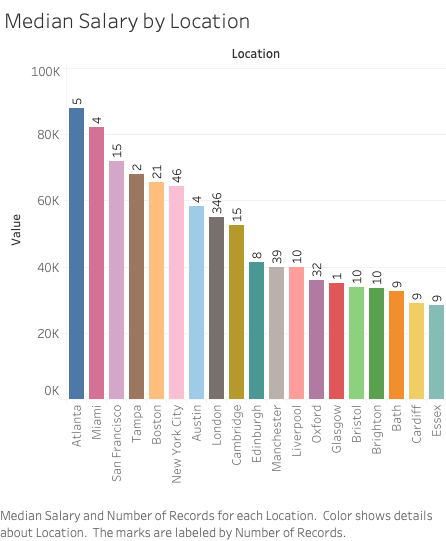

In [492]:
from IPython.display import Image

#looking at median salary by location 
Image(filename='./visuals/median salary by location.png') 

#Median Salaries are higher in the USA than in UK, with Atlanta having the highest median salary and Essex having the lowest median salary.

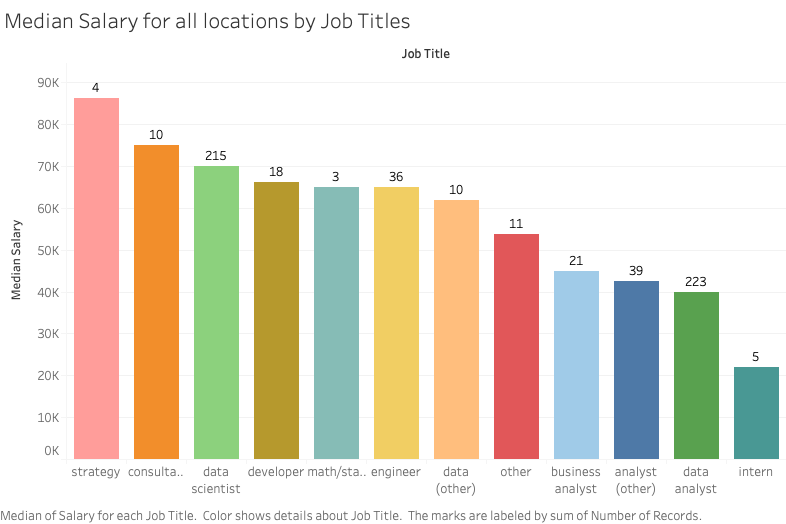

In [493]:
Image(filename='./visuals/median salary by title.png') 
#Jobs with 'strategy' in the title earn the highest median salary on average at about 86,000, and interns earn the lowest at about 20,000

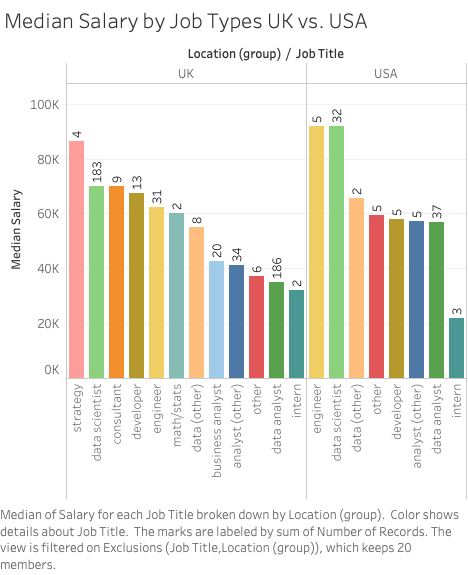

In [494]:
#comparing salaries of different job titles between US and UK
#there were a couple job titles that only had 1 record in the US, so those were deleted

Image(filename = './visuals/usa vs uk job title salary.png')

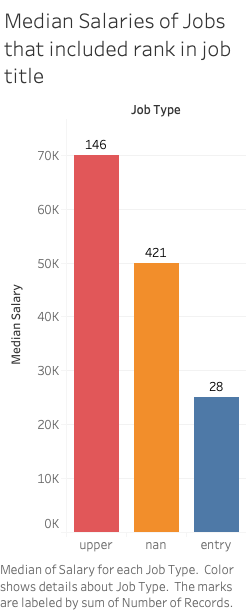

In [495]:
Image(filename = './visuals/job types.png')
#upper = manager, lead, head, senior
#entry = junior, graduate, intern

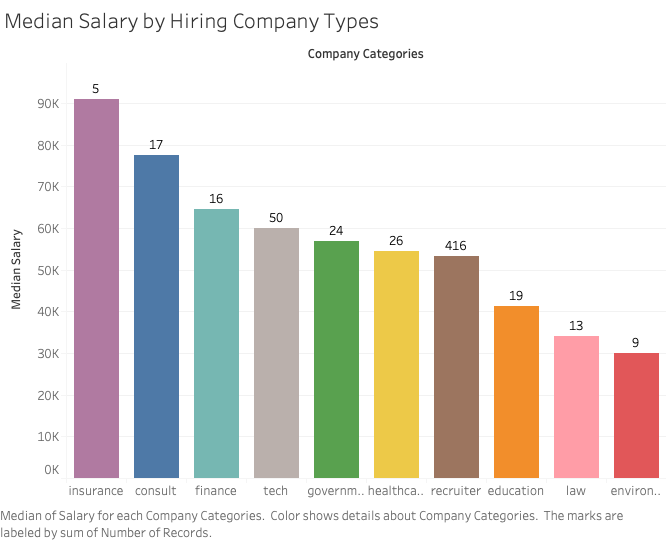

In [496]:
Image(filename = './visuals/salary by company type.png')

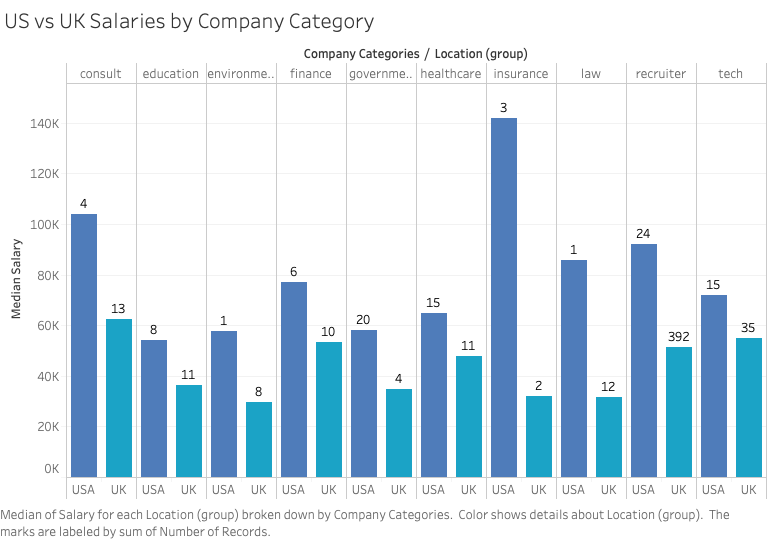

In [497]:
Image(filename = './visuals/us vs uk company category salary.png')

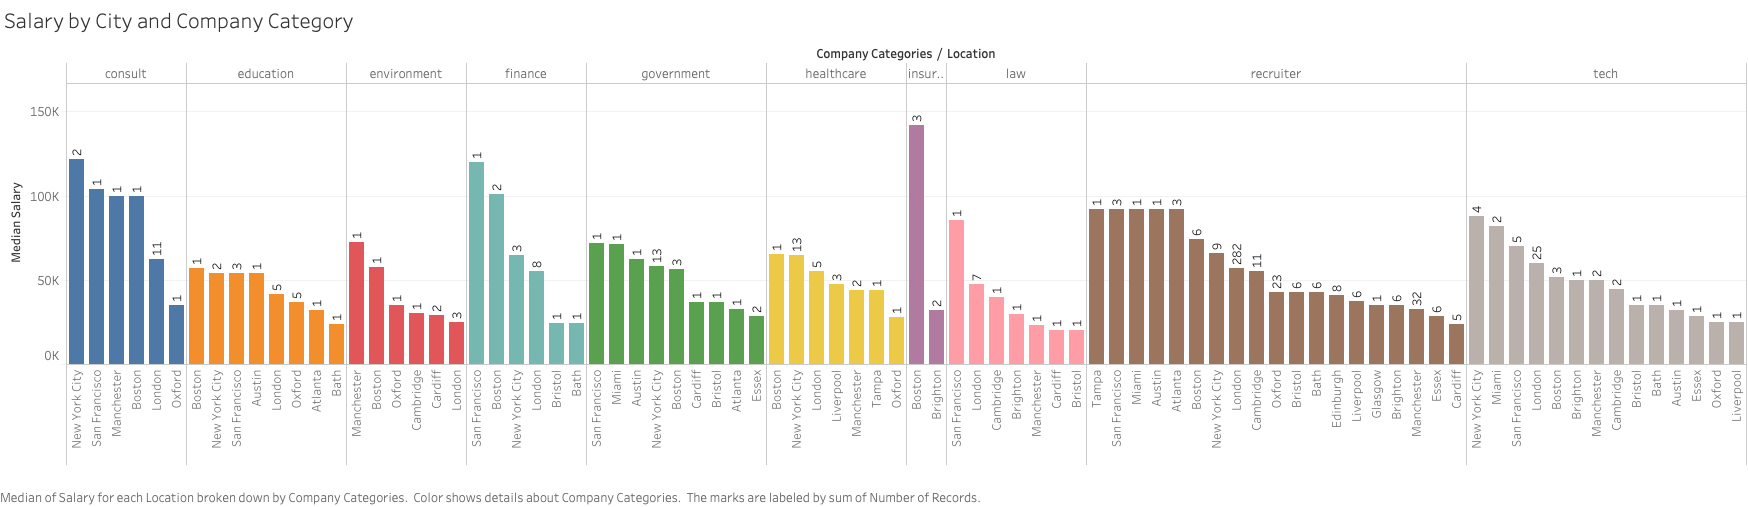

In [498]:
Image(filename = './visuals/city and company category salary.png')

#### Findings:
Impact of Location:
Median Salaries are higher in the USA than in UK, with Atlanta having the highest median salary and Essex having the lowest median salary.

Job Title:
When looking at all roles, regardless of location, jobs with 'strategy' in the title earn the highest median salary on average at about 86,000, and interns earn the lowest at about 20,000. When this data is split by location, ‘strategy’ positions earn the most in the USA at around 85,000, but ‘engineer’ and ‘data scientist’ earn the most in the UK at about 90,000.

Company Types:
In the US, insurance companies pay the highest salaries, and in the UK consultancies and tech related companies pay the highest. 

## Use classification model to predict if a job will be above or below the median salary of all jobs.

This will be a binary classification problem, predicting two classes - High or Low Salary. Doing this as a classification model rather than a regression will eliminate some of the noise from some of the extreme salaries. 

In [24]:
median_salary = all_jobs.Salary.median()
median_salary

55000.0

In [25]:
# Create Salary_binary column tells if the given salary is above (1) or below (0) median

all_jobs['Salary_binary'] = (all_jobs.Salary >= median_salary) *1
all_jobs

,Company,Description,Job,Location,Salary,Company Categories,Job Type,Job Title,Salary_binary
0,inspiratia,Previous experience as a data analyst or relev...,Data Analyst,London,25000,environment,nan,data analyst,0
1,BlackLion Law,Analyse and interpret data using statistical t...,Data Analyst,London,20000,law,nan,data analyst,0
2,Ampersand Consulting,Experience of analyzing large and complex data...,"Data Analyst (Excel, SQL, Data)",London,25500,consult,nan,data analyst,0
3,Lifeways,Support consolidation and cleanse of the Group...,Business Data Analyst,London,55000,healthcare,nan,data analyst,1
4,Metrica Recruitment,Will have at least 3 years of financial servic...,FinTech Lead Data Scientist,London,70000,recruiter,upper,data scientist,1
...,...,...,...,...,...,...,...,...,...
10,"Rockdale County, Georgia",This position is responsible for the developme...,GIS Analyst I,Atlanta,32405,government,nan,analyst (other),0
11,Georgia State University,Explore data visualization with a goal of gain...,Development Data Analyst,Atlanta,32000,education,nan,data analyst,0
12,ODSC Hiring Partner,Ideally 1+ years of work experiences as a data...,Data Scientist,Atlanta,92000,recruiter,nan,data scientist,1
13,Beyond Outsourcing Inc.,"Strong coder, with experience building models ...",Data Scientist - NLP - OCR Engineer,Atlanta,120000,recruiter,nan,data scientist,1


### What is the baseline accuracy for this model?

In [26]:
# Since the data is split evenly above and below the median salary, the baseline would be roughly 50%

baseline = all_jobs.Salary_binary.value_counts(normalize= True)
baseline

1    0.50084
0    0.49916
Name: Salary_binary, dtype: float64

### Using ONLY Location as a predictor for if a salary will be High or Low

In [28]:
X = all_jobs[['Location']]
y = all_jobs.Salary_binary

In [29]:
#dummify location columns
X_dum = pd.get_dummies(X, drop_first = True)

In [30]:
#train test split

X_train, X_test, y_train, y_test = train_test_split(
    X_dum, y, stratify = y, test_size=0.2, random_state=1)


#### Logistic RegressionCV

In [31]:
model = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, max_iter = 1000)
model.fit(X_train, y_train)
#use the C calculated from CV model, plug into regular Logistic Regression model
model.Cs

logreg = LogisticRegression(C = 10, max_iter = 1000)


logreg.fit(X_train, y_train)

#calcuate scores
log_reg_train = logreg.score(X_train, y_train)
log_reg_test = logreg.score(X_test, y_test)
log_reg_cv = (cross_val_score(logreg, X_train, y_train, cv = 10)).mean()

#put scores into dataframe so that it is easy to compare different model scores later
log_reg_df = pd.DataFrame([log_reg_train, log_reg_test, log_reg_cv], index = ['train', 'test', 'cv'], columns = ['Log Reg CV'])

print('Logistic Regression CV Scores: \n')
print('train score: ', log_reg_train)
print('test score: ', log_reg_test)
print('cv score: ', log_reg_cv)

Logistic Regression CV Scores: 

train score:  0.6512605042016807
test score:  0.5966386554621849
cv score:  0.6407801418439717


In [32]:
predictions = logreg.predict(X_test)


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.29      0.41        59
           1       0.56      0.90      0.69        60

    accuracy                           0.60       119
   macro avg       0.65      0.59      0.55       119
weighted avg       0.65      0.60      0.55       119



##### Feature Importance & Model Coefficients

In [33]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_[0], index=X_train.columns, columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]


,coefficients,coef_abs
Location_New York City,1.093940,1.093940
Location_Essex,-0.782901,0.782901
Location_Boston,0.774446,0.774446
Location_Liverpool,-0.726248,0.726248
Location_San Francisco,0.706560,0.706560
Location_Oxford,-0.667926,0.667926
Location_Cardiff,-0.665006,0.665006
Location_Miami,0.624009,0.624009
Location_Brighton,-0.621367,0.621367
Location_London,0.598084,0.598084


In this model, a job located in NYC, Boston and San Fran has a large influence on having a high paying job since their coefficients are positive and relatively large. Jobs located in Essex and Liverpool have negative coefficents, so a job in those locations would likely be paying below median

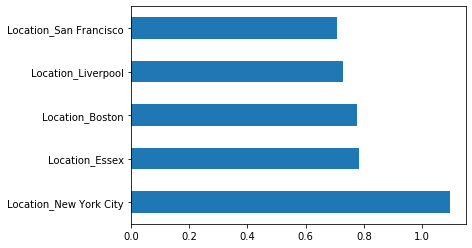

In [34]:
#these are the top 5 cities that have the largest impact on salary

df_coef['coef_abs'].sort_values(ascending = False).head(5).plot(kind='barh');

#### Decision Tree with Grid Search CV

In [35]:
# gridsearch params
dtr_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}


# set the gridsearch
dt_model = DecisionTreeClassifier(random_state = 1)
dtc_gs = GridSearchCV(dt_model, dtr_params, cv=5, n_jobs=2)
dtc_gs.fit(X_train, y_train)

#pull out the model with the best parameters found in the gridsearch, and find scores
best_model = dtc_gs.best_estimator_

dt_train = best_model.score(X_train, y_train)
dt_test = best_model.score(X_test, y_test)
dt_cv = (cross_val_score(best_model, X_train, y_train, cv = 10)).mean()

#put scores into dataframe so that it is easy to compare different model scores later
dt_df = pd.DataFrame([dt_train, dt_test, dt_cv], index = ['train', 'test', 'cv'], columns = ['Decision Tree'])

print('Decision Tree Classifier Scores: \n')
print('train score: ', dt_train)
print('test score: ', dt_test)
print('cv score: ', dt_cv)

Decision Tree Classifier Scores: 

train score:  0.6533613445378151
test score:  0.5966386554621849
cv score:  0.6408244680851064


In [36]:
predictions = best_model.predict(X_test)


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.29      0.41        59
           1       0.56      0.90      0.69        60

    accuracy                           0.60       119
   macro avg       0.65      0.59      0.55       119
weighted avg       0.65      0.60      0.55       119



##### Feature Importance & Model Coefficients

In [37]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
15,Location_Oxford,0.195510
10,Location_Liverpool,0.125490
8,Location_Essex,0.118134
12,Location_Manchester,0.108248
6,Location_Cardiff,0.101980
3,Location_Brighton,0.100318
1,Location_Bath,0.062074
14,Location_New York City,0.059764
13,Location_Miami,0.038140
2,Location_Boston,0.027880


The feature importance of this model has Oxford, Liverpool, and Essex as the highest values, indcating that these locations have the largest impacts on salaries.

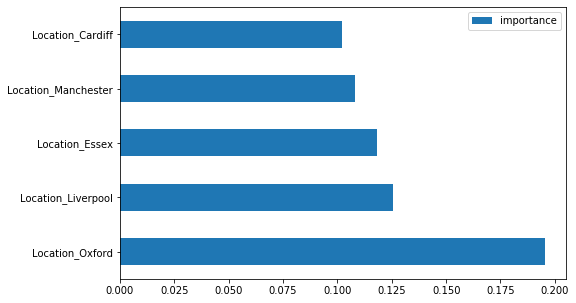

In [38]:
pd.DataFrame(best_model.feature_importances_,
             columns=['importance'],
             index=X_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).head(5).plot(kind='barh', figsize=(8, 5));

#### Ada Boost Classifier Model

In [39]:
#use best_model from Decision Tree Classifier, 
#this gave a higher CV score on this model than using a simple Decision Tree Classifier

boost_model = AdaBoostClassifier(base_estimator=best_model,
                           n_estimators=100,
                           random_state=1)

boost_model.fit(X_train, y_train)

boost_train = boost_model.score(X_train, y_train)
boost_test = boost_model.score(X_test, y_test)
boost_cv = (cross_val_score(boost_model, X_train, y_train, cv = 10)).mean()

#put scores into dataframe so that it is easy to compare different model scores later
boost_df = pd.DataFrame([boost_train, boost_test, boost_cv], index = ['train', 'test', 'cv'], columns = ['Ada Boost'])


print('Ada Boost Classifier Scores: \n')
print('train score: ', boost_train)
print('test score: ', boost_test)
print('cv score: ', boost_cv)

Ada Boost Classifier Scores: 

train score:  0.6533613445378151
test score:  0.5966386554621849
cv score:  0.6387411347517731


In [40]:
predictions = boost_model.predict(X_test)


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.29      0.41        59
           1       0.56      0.90      0.69        60

    accuracy                           0.60       119
   macro avg       0.65      0.59      0.55       119
weighted avg       0.65      0.60      0.55       119



In [41]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': boost_model.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
1,Location_Bath,0.172032
7,Location_Edinburgh,0.156619
17,Location_Tampa,0.081128
12,Location_Manchester,0.057528
3,Location_Brighton,0.035288
15,Location_Oxford,0.033507
16,Location_San Francisco,0.030097
2,Location_Boston,0.027363
14,Location_New York City,0.021403
11,Location_London,0.016579


in this model, jobs in Bath, Edinburgh, and Tampa had the highest influence on whether a job was expected to be high paying or not

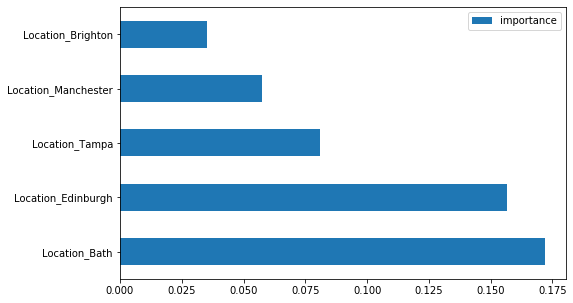

In [42]:
pd.DataFrame(boost_model.feature_importances_,
             columns=['importance'],
             index=X_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).head(5).plot(kind='barh', figsize=(8, 5));

#### Bagging Classifier

In [43]:
#use best_model from decision tree as the base estimator because this increased the CV score of the model

bc1 = BaggingClassifier(base_estimator = best_model, max_samples = 1.0, n_jobs = 1, max_features = 1.0, random_state = 1)
bc1.fit(X_train, y_train)

gs_params = {'max_features': [.3, .5, .8, 1.0], 'max_samples': [.3, .5, .8, 1.0], 'n_jobs': [-1, 1]}
dt_gridsearch = GridSearchCV(bc1, gs_params, n_jobs = 2, cv = 5)

dt_gridsearch.fit(X_train, y_train)

#use the best parameters defined by the gridsearch as the parameters for the model best_bc
best_bc = dt_gridsearch.best_estimator_

b_train = best_bc.score(X_train, y_train)
b_test = best_bc.score(X_test, y_test)
b_cv = (cross_val_score(best_bc, X_train, y_train, cv = 10)).mean()


#put scores into dataframe so that it is easy to compare different model scores later
b_df = pd.DataFrame([b_train, b_test, b_cv], index = ['train', 'test', 'cv'], columns = ['Bagging'])

print('Bagging Classifier Scores: \n')
print('train score: ', b_train)
print('test score: ', b_test)
print('cv score: ', b_cv)

Bagging Classifier Scores: 

train score:  0.6428571428571429
test score:  0.5966386554621849
cv score:  0.6429078014184397


In [44]:
predictions = best_bc.predict(X_test)


print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.29      0.41        59
           1       0.56      0.90      0.69        60

    accuracy                           0.60       119
   macro avg       0.65      0.59      0.55       119
weighted avg       0.65      0.60      0.55       119



In [45]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in best_bc.estimators_
], axis=0)

fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
14,Location_New York City,0.151707
15,Location_Oxford,0.132258
11,Location_London,0.114541
3,Location_Brighton,0.095875
2,Location_Boston,0.086874
12,Location_Manchester,0.079913
10,Location_Liverpool,0.068982
8,Location_Essex,0.043778
6,Location_Cardiff,0.041434
7,Location_Edinburgh,0.040901


in this model, a job located in NYC, Oxford, and London had the highest influence on whether a job would be high paying or not

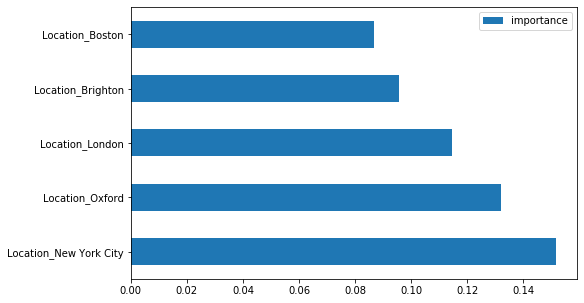

In [46]:
pd.DataFrame(feature_importances,
             columns=['importance'],
             index=X_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).head(5).plot(kind='barh', figsize=(8, 5));

#### create a dataframe of all scores from the four models above



In [47]:
all_models = pd.concat([log_reg_df, dt_df, b_df, boost_df], axis = 1)
all_models

,Log Reg CV,Decision Tree,Bagging,Ada Boost
train,0.651261,0.653361,0.642857,0.653361
test,0.596639,0.596639,0.596639,0.596639
cv,0.640780,0.640824,0.642908,0.638741


### Score Evaluation
In the four models above, Bagging Classifier received the highest CV score of .6429


The most important features for this model were NYC, Oxford,  London and Brighton. According to the Bagging Classifier, job postings in these locations resulted in higher predicted salaries.

Although Bagging Classifer performed the best, all four of the model scores were quite close to one another, and were about .1 higher than the baseline of 0.5 indicating that the models made better predictions. However, it is likely that by adding other features these scores can improve.


### Adding additional features from data

#### redefine X and y
now predictors will be Location, category of the hiring company, job type(entry/upper), and job title categories



In [48]:
X_new = all_jobs[['Location', 'Company Categories', 'Job Title', 'Job Type']]
y_new = all_jobs['Salary_binary']

#dummify new X columns

X_new_dum = pd.get_dummies(X_new, drop_first = True)

In [49]:
#train test split 

#couldnt stratify on y here because smallest class would only have 1 sample
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new_dum, y_new, test_size=0.2, stratify = y_new, random_state=1)

In [50]:
X_train_new.shape

(476, 40)

In [51]:
y_train_new.shape

(476,)

#### Logistic Regression CV model

In [52]:
model_2 = LogisticRegressionCV(solver='lbfgs', multi_class='auto', cv=5, max_iter = 1000)
model_2.fit(X_train_new, y_train_new)

model_2.Cs

#fit the logistic regression with C from CV

logreg = LogisticRegression(C = 10, max_iter = 1000)
logreg.fit(X_train_new, y_train_new)

#calculate scores and save in variables
new_lr_train = logreg.score(X_train_new, y_train_new)
new_lr_test = logreg.score(X_test_new, y_test_new)
new_lr_cv = (cross_val_score(logreg, X_train_new, y_train_new, cv = 10)).mean()

#create dataframe of scores so that model scores can easily be compared later
new_lr = pd.DataFrame([new_lr_train, new_lr_test, new_lr_cv], index = ['train', 'test', 'cv'], columns = ['Logistic Regression CV'])

print('Logistic Regression Scores: \n')
print('train score: ', new_lr_train)
print('test score: ', new_lr_test)
print('cv score: ', new_lr_cv)

Logistic Regression Scores: 

train score:  0.8235294117647058
test score:  0.7563025210084033
cv score:  0.7774822695035462


In [53]:
predictions = logreg.predict(X_test_new)


log_reg_report = metrics.classification_report(y_test_new, predictions)
print(log_reg_report)

              precision    recall  f1-score   support

           0       0.77      0.73      0.75        59
           1       0.75      0.78      0.76        60

    accuracy                           0.76       119
   macro avg       0.76      0.76      0.76       119
weighted avg       0.76      0.76      0.76       119



In [54]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model_2.coef_[0], index=X_train_new.columns, columns=['coefficients'])

# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = 'coef_abs', ascending = False)[:10]

,coefficients,coef_abs
Location_Liverpool,-4.758848,4.758848
Job Type_upper,4.254977,4.254977
Job Title_math/stats,3.849379,3.849379
Job Type_nan,3.298404,3.298404
Job Title_engineer,3.195101,3.195101
Job Title_data (other),3.186982,3.186982
Company Categories_education,-3.157545,3.157545
Job Title_intern,-2.967966,2.967966
Job Title_consultant,2.905983,2.905983
Location_Cardiff,-2.894455,2.894455


in this model, upper level positions, math/stats related jobs all had a large impact on increasing expected salary by contrast, a job located in Liverpool has a largely negative impact on salary and causes salary predictions to be lower

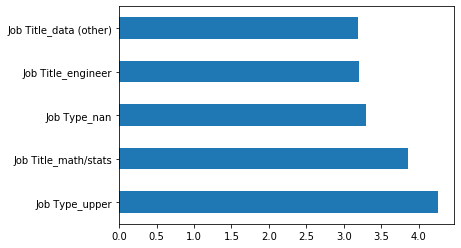

In [55]:
#these are the top 5 features that make the largest impact on salary

df_coef['coefficients'].sort_values(ascending = False).head(5).plot(kind='barh');

#### Decision Tree with GridSearchCV

In [56]:
# gridsearch params
dtr_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}


# set the gridsearch
dt_model = DecisionTreeClassifier(random_state = 1)
dtc_gs = GridSearchCV(dt_model, dtr_params, cv=5, n_jobs=2)
dtc_gs.fit(X_train_new, y_train_new)

#pull out the model with the best parameters found in the gridsearch, and find scores
best_model_new = dtc_gs.best_estimator_

new_dt_train = best_model_new.score(X_train_new, y_train_new)
new_dt_test = best_model_new.score(X_test_new, y_test_new)
new_dt_cv = (cross_val_score(best_model_new, X_train_new, y_train_new, cv = 10)).mean()

new_dt = pd.DataFrame([new_dt_train, new_dt_test, new_dt_cv], index = ['train', 'test', 'cv'], columns = ['Decision Tree'])

print('Decision Tree Classifier Scores: \n')
print('train score: ', new_dt_train)
print('test score: ', new_dt_test)
print('cv score: ', new_dt_cv)


Decision Tree Classifier Scores: 

train score:  0.8151260504201681
test score:  0.7478991596638656
cv score:  0.7435283687943263


In [57]:
predictions = best_model_new.predict(X_test_new)

dt_report = metrics.classification_report(y_test_new, predictions)
print(dt_report)

              precision    recall  f1-score   support

           0       0.84      0.61      0.71        59
           1       0.70      0.88      0.78        60

    accuracy                           0.75       119
   macro avg       0.77      0.75      0.74       119
weighted avg       0.77      0.75      0.74       119



In [58]:
fi = pd.DataFrame({
    'feature': X_train_new.columns,
    'importance': best_model_new.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
31,Job Title_data scientist,0.182948
39,Job Type_upper,0.122225
30,Job Title_data analyst,0.094125
33,Job Title_engineer,0.090130
38,Job Type_nan,0.076168
10,Location_Liverpool,0.053461
8,Location_Essex,0.040292
11,Location_London,0.036757
14,Location_New York City,0.032950
37,Job Title_strategy,0.027477


in this model the features with the highest importance were jobs with data science, analyst, or engineer in the title, and an upper level role these aspects would have the greatest impact on predicted salary

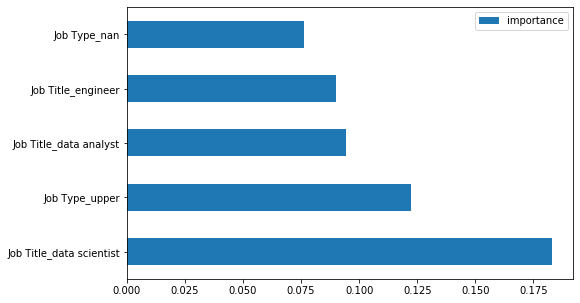

In [59]:
pd.DataFrame(best_model_new.feature_importances_,
             columns=['importance'],
             index=X_new_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).head(5).plot(kind='barh', figsize=(8, 5));

#### Ada Boost Classifier

In [60]:
base_estimator = DecisionTreeClassifier(max_depth=3)
boost_model_2 = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)

boost_model_2.fit(X_train_new, y_train_new)

new_ada_train = boost_model_2.score(X_train_new, y_train_new)
new_ada_test = boost_model_2.score(X_test_new, y_test_new)
new_ada_cv = (cross_val_score(boost_model_2, X_train_new, y_train_new, cv = 10)).mean()

new_ada = pd.DataFrame([new_ada_train, new_ada_test, new_ada_cv], index = ['train', 'test', 'cv'], columns = ['Ada Boost'])

print('Ada Boost Classifier Scores: \n')
print('train score: ', new_ada_train)
print('test score: ', new_ada_test)
print('cv score: ', new_ada_cv)

Ada Boost Classifier Scores: 

train score:  0.8634453781512605
test score:  0.7478991596638656
cv score:  0.7437056737588652


In [61]:
predictions = boost_model_2.predict(X_test_new)

ada_report = metrics.classification_report(y_test_new, predictions)
print(ada_report)

              precision    recall  f1-score   support

           0       0.80      0.66      0.72        59
           1       0.71      0.83      0.77        60

    accuracy                           0.75       119
   macro avg       0.76      0.75      0.75       119
weighted avg       0.75      0.75      0.75       119



In [62]:
fi = pd.DataFrame({
    'feature': X_train_new.columns,
    'importance': boost_model_2.feature_importances_
})

fi.sort_values('importance', ascending=False, inplace=True)
fi[:10]

,feature,importance
25,Company Categories_recruiter,0.088365
11,Location_London,0.072465
31,Job Title_data scientist,0.062867
30,Job Title_data analyst,0.051992
1,Location_Bath,0.051117
12,Location_Manchester,0.050575
20,Company Categories_finance,0.050013
5,Location_Cambridge,0.049889
39,Job Type_upper,0.049032
26,Company Categories_tech,0.048570


this models features with the highest values were jobs that were posted by recruiters, located in London and were for either data scientist or data analyst jobs these elements would have the largest impact on predicted salary

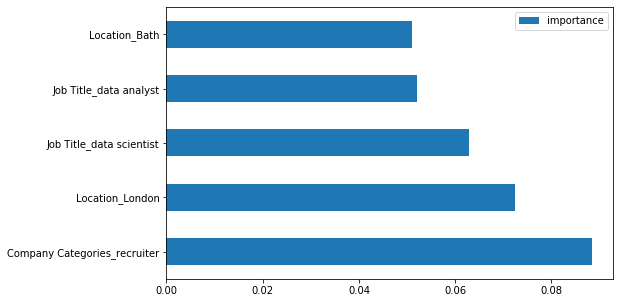

In [63]:
pd.DataFrame(boost_model_2.feature_importances_,
             columns=['importance'],
             index=X_new_dum.columns
             ).sort_values(by='importance', ascending=False
                           ).head(5).plot(kind='barh', figsize=(8, 5));

#### Bagging Classifier

In [64]:
#use best_model from decision tree as the base estimator

bc2 = BaggingClassifier(base_estimator = best_model_new, max_samples = 1.0, n_jobs = 1, max_features = 1.0, random_state = 1)
bc2.fit(X_train_new, y_train_new)

gs_params = {'max_features': [.3, .5, .8, 1.0], 'max_samples': [.3, .5, .8, 1.0], 'n_jobs': [-1, 1]}
dt_gridsearch = GridSearchCV(bc2, gs_params, n_jobs = 2, cv = 5)

dt_gridsearch.fit(X_train_new, y_train_new)

best_bc_2 = dt_gridsearch.best_estimator_

b_train_new = best_bc_2.score(X_train_new, y_train_new)
b_test_new = best_bc_2.score(X_test_new, y_test_new)
b_cv_new = (cross_val_score(best_bc_2, X_train_new, y_train_new, cv = 10)).mean()


#put scores into dataframe so that it is easy to compare different model scores later
new_b_df = pd.DataFrame([b_train_new, b_test_new, b_cv_new], index = ['train', 'test', 'cv'], columns = ['Bagging'])

print('Bagging Classifier Scores: \n')
print('train score: ', b_train_new)
print('test score: ', b_test_new)
print('cv score: ', b_cv_new)

Bagging Classifier Scores: 

train score:  0.8298319327731093
test score:  0.7310924369747899
cv score:  0.775177304964539


In [65]:
predictions = best_bc_2.predict(X_test_new)

bagging_report = metrics.classification_report(y_test_new, predictions)
print(bagging_report)

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        59
           1       0.72      0.77      0.74        60

    accuracy                           0.73       119
   macro avg       0.73      0.73      0.73       119
weighted avg       0.73      0.73      0.73       119



In [66]:
pd.DataFrame(list(zip(X_train_new.columns,best_bc_2[1].feature_importances_))).sort_values(by=1,ascending=False)[:10]

,0,1
12,Location_Manchester,0.389746
6,Location_Cardiff,0.133811
11,Location_London,0.087353
13,Location_Miami,0.075570
23,Company Categories_insurance,0.074599
25,Company Categories_recruiter,0.034128
22,Company Categories_healthcare,0.031621
20,Company Categories_finance,0.027214
14,Location_New York City,0.017155
27,Job Title_business analyst,0.016567


in this model, the highest influencers of predicted salary were the jobs being located in Manchester, Cardiff, and London this was the only model that included all features that had locations having the greatest influence on predicted salary

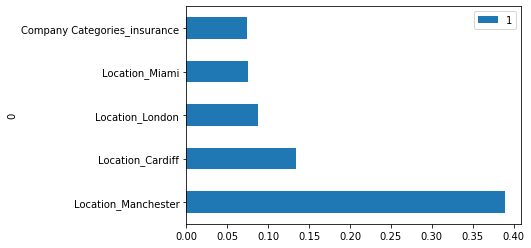

In [67]:
pd.DataFrame(list(zip(X_train_new.columns,best_bc_2[1].feature_importances_))).sort_values(by=1,ascending=False).head(5).plot(kind='barh',
    x=0,y=1)
plt.show()

#### Compare model scores

In [68]:
new_models = pd.concat([new_lr, new_dt, new_ada, new_b_df], axis = 1)
new_models

,Logistic Regression CV,Decision Tree,Ada Boost,Bagging
train,0.823529,0.815126,0.863445,0.829832
test,0.756303,0.747899,0.747899,0.731092
cv,0.777482,0.743528,0.743706,0.775177


### Score Evaluation

All of these models performed relatively similarly, but the best model is Logistic Regression CV because it had the highest CV score at .777

In the Logistic Regression CV model, upper level positions, math/stats related jobs all had a large impact on increasing expected salary. By contrast, a job located in Liverpool has a largely negative impact on salary and causes salary predictions to be lower.

Since these four models did substantally better than the previous models that relied only on location, it can be concluded that factors such as job types, roles, and types of companies can impact how high the salary is.

# Model evaluation:

In the case that we are predicting if someone will have a high or low salary, it may be better to incorrectly tell them that they would get a lower salary job than tell them incorrectly that they would get a high salary job. To accomodate this, I will adjust one of the models from above. 

## Recall vs. Precision Tradeoff

In initally constructing models to predict salary, the main goal is to achieve accurate predictions of whether or not a job's details indicate if the salary will be above or below the median salary. However, in real life examples it is important to take in consideration the impact an incorrect prediction could have. For instance, it would be much better if someone was told that they would recieve a low salary and it later turned out that they would actually make more money. In order to prevent telling someone incorrectly that they will earn more than the median, it was important to increase the precision of the model which ensures that there are less false positives. 

Increasing precison comes with other drawbacks, such as decreasing the model's accuracy and recall scores. Accuracy and recall decrease because we may be now increasing the number of false negatives (predicting that someone will earn below the median incorrectly). Although in an ideal world we would want high values for accuracy, precision, and recall, some of these scores will be lowered if we want to alther another. In this example, if we favored a high-recall model it would cause there to be a lower amount of false negatives, meaning that there would be fewer predictions that said that a job's salary would be lower than median if it was really higher. This would cause the model to lean towards predicting a salary higher than the median to avoid predicting incorrectly that it was lower. For this scenerio that would not be a good way to predict, since people would think they would receive a high salary when they would actually make a lower one. 

### Print classification reports from all four models which used all features
In this scenerio the model should have low false positives, meaning that someone is not told they will have a high salary if they will actually have a low one. In this case, precision should be high, indicating that false positives are low. By tailoring our model to do this, we may increase the amount of false negatives, but we will ensure that people are pleasantly suprised about having a high salary rather than suprised to have a low salary after expecting a high one. 

In [69]:
print('logistic regression CV classification report: \n\n', log_reg_report)
print()
print()
print('decision tree report: \n\n', dt_report)
print()
print()
print('ada boost report: \n\n', ada_report)
print()
print()
print('bagging classifier report: \n\n', bagging_report)

logistic regression CV classification report: 

               precision    recall  f1-score   support

           0       0.77      0.73      0.75        59
           1       0.75      0.78      0.76        60

    accuracy                           0.76       119
   macro avg       0.76      0.76      0.76       119
weighted avg       0.76      0.76      0.76       119



decision tree report: 

               precision    recall  f1-score   support

           0       0.84      0.61      0.71        59
           1       0.70      0.88      0.78        60

    accuracy                           0.75       119
   macro avg       0.77      0.75      0.74       119
weighted avg       0.77      0.75      0.74       119



ada boost report: 

               precision    recall  f1-score   support

           0       0.80      0.66      0.72        59
           1       0.71      0.83      0.77        60

    accuracy                           0.75       119
   macro avg       0.76      

In [70]:
logreg.predict_proba(X_test_new)[:5]

array([[0.97883453, 0.02116547],
       [0.93536535, 0.06463465],
       [0.98492181, 0.01507819],
       [0.89836861, 0.10163139],
       [0.88681966, 0.11318034]])

### Since Logistic Regression CV initally has the highest precision score for class 1, I chose that model to alter and continue to improve the precision score. 

Below are the initial predictions on whether a job will be predicted to be in class 0 (below median) or class 1 (above median) based on the Logistic Regression CV model. The current threshold for a prediction is .5, indicating that if a probability is higher than .5 it will be predicted to be in that class. By increasing the threshold, fewer predictions will be made for class 1 (having a salary over the median) and therefore decreasing the number of false positives. 

In [692]:
Y_pp = pd.DataFrame(logreg.predict_proba(X_test_new), 
             columns=['class_0_pp', 'class_1_pp'])
Y_pp.head()

,class_0_pp,class_1_pp
0,0.978835,0.021165
1,0.935365,0.064635
2,0.984922,0.015078
3,0.898369,0.101631
4,0.886820,0.113180


#### Create a function to alter the threshold for making predictions

In [710]:
def predict_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0
    
Y_pp['pred_class_thresh'] = Y_pp.class_1_pp.apply(predict_threshold, 
                                                threshold=0.85)
Y_pp.head(5)

,class_0_pp,class_1_pp,pred_class_thresh
0,0.978835,0.021165,0
1,0.935365,0.064635,0
2,0.984922,0.015078,0
3,0.898369,0.101631,0
4,0.886820,0.113180,0


#### This graph shows the tradeoff between threshold and accuracy. At a threshold of .85, as I have changed the threshold to above, the model has already lost a great deal of accuracy, but if the priority is to prevent false positives accuracy can be sacrificed a bit to allow for a model with high precision.

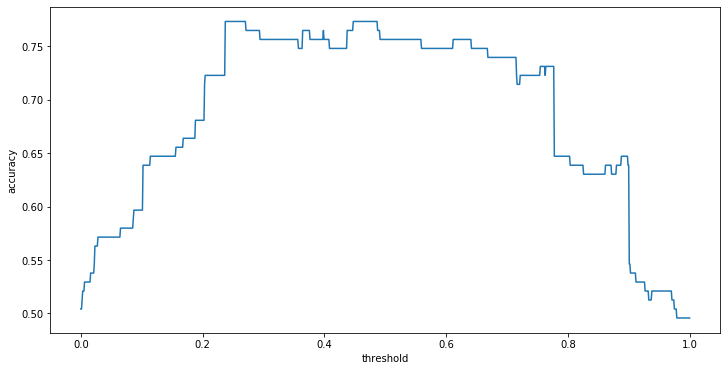

In [711]:
accuracies = np.array(
    [(i, accuracy_score(y_test_new, Y_pp.class_1_pp.apply(predict_threshold, threshold=i))) 
        for i in np.linspace(0, 1, 1000)])

plt.figure(figsize=(12, 6))
plt.plot(accuracies[:, 0], accuracies[:, 1])
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

In [712]:
print(metrics.classification_report(y_test_new, Y_pp.pred_class_thresh))

              precision    recall  f1-score   support

           0       0.58      0.92      0.71        59
           1       0.81      0.35      0.49        60

    accuracy                           0.63       119
   macro avg       0.69      0.63      0.60       119
weighted avg       0.70      0.63      0.60       119



### Increase Threshold to .85
By increasing the threshold from .5 to .85 the model predicts class 1 (having a high salary) less often, and therefore decreases the number of false negatives and increases the precision score for class 1. The original precision was .75 and now the precision is .81. If the threshold was set further to .9 it would have a perfect precision score, but the model would suffer from inaccuracy since the predictions would simply be for class 0 nearly every time. 

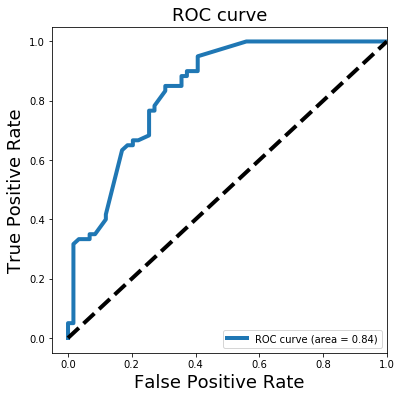

In [696]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test_new, Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#the area under the curve is .82, which is quite good considering that .5 would be a baseline prediction


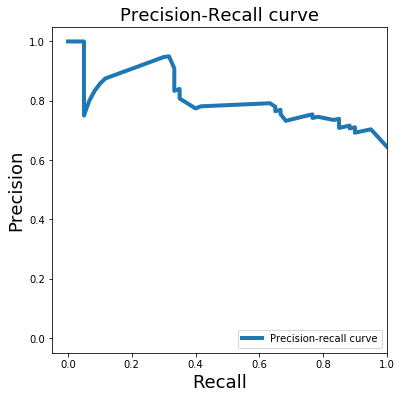

In [697]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(y_test_new, Y_pp.class_1_pp)


# Plot of a precision-recall curve for class 1 (above median salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

## Analyze AUC and Precision Recall for other models
The bagging classifier model had the highest AUC, which indicates that it is a strong model.  However it was a bit lower than the the AUC for the Logistic Regression model that was adjusted to increase precision. Bagging also had a more controlled recall/precision graph, where the precision remains high while recall also increases. 

### Decision Tree

In [77]:
dt_Y_pp = pd.DataFrame(best_model_new.predict_proba(X_test_new), 
             columns=['class_0_pp', 'class_1_pp'])

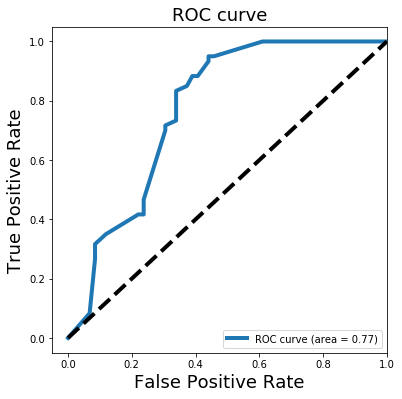

In [73]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fpr, tpr, threshold = roc_curve(y_test_new, dt_Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()


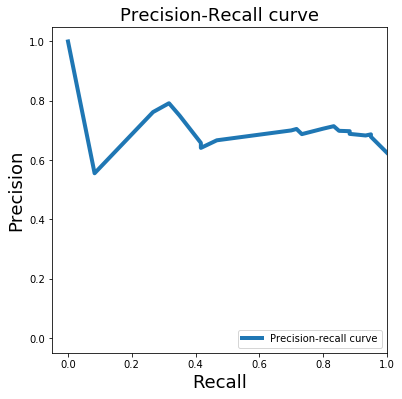

In [74]:
precision, recall, threshold = precision_recall_curve(y_test_new, dt_Y_pp.class_1_pp)


# Plot of a precision-recall curve for class 1 (above median salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Ada Boost Classifier

In [76]:
a_Y_pp = pd.DataFrame(boost_model_2.predict_proba(X_test_new), 
             columns=['class_0_pp', 'class_1_pp'])

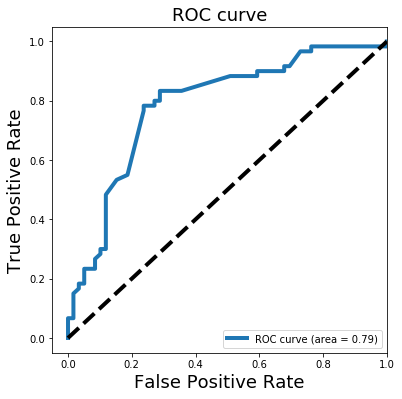

In [78]:
fpr, tpr, threshold = roc_curve(y_test_new, a_Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()


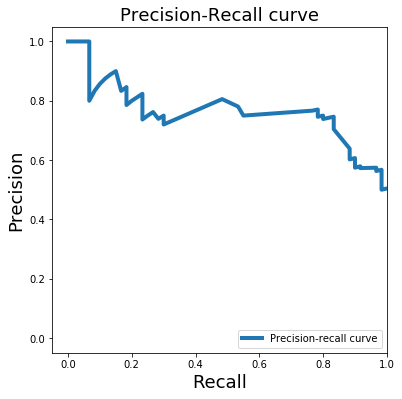

In [79]:
precision, recall, threshold = precision_recall_curve(y_test_new, a_Y_pp.class_1_pp)


# Plot of a precision-recall curve for class 1 (above median salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Bagging Classifier

In [80]:
b_Y_pp = pd.DataFrame(best_bc_2.predict_proba(X_test_new), 
             columns=['class_0_pp', 'class_1_pp'])

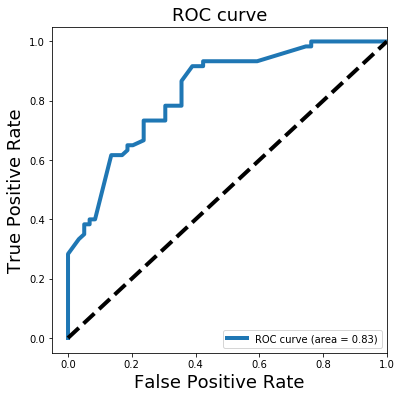

In [81]:
fpr, tpr, threshold = roc_curve(y_test_new, b_Y_pp.class_1_pp)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()


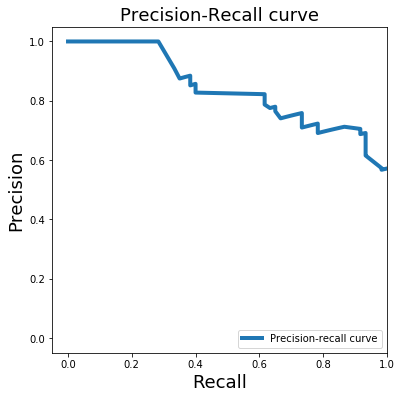

In [82]:
precision, recall, threshold = precision_recall_curve(y_test_new, b_Y_pp.class_1_pp)


# Plot of a precision-recall curve for class 1 (above median salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Executive Summary

In this project I aimed to predict if a job's salary would be above or below the median salary based on details of the job posting. The first step was to collect data of many different job postings on Indeed.com that included a salary in the posting. Many listings were posted several times, so those additional postings had to be removed so that they were not used more than once. Many job postings also did not include a salary, which would not be helpful to include at this stage. Even though there were thousands of postings on Indeed for these cities, once duplicates and postings without salary were deleted, the data diminished dramatically and left me with about 600 postings to base the model on. Ideally there would be more data to analyze, but this is a good amount to start with.

I collected data from various different cities in the U.K. and United States, and ensured that the salaries were all converted to pounds. In this inital data I collected information on the job's title, company, location, description, and salary. Since many different companies had listings and there would often only be one job per compay name, I decided that the individual companies name would not help predict salary. Instead, I grouped companies into categories based on the type of company that posted the job. In this stage I found that a vast majority were posted by recruitment companies, but other categories included healthcare, consulting, law and several others. 

Similarly, job titles were also very unique and there may only be one listing with the specific title. It was more beneficial to categorize job titles as well. Job titles were split into larger groups based on what the title indicated. For example, job titles of "Junior Data Scientist" and "Data Scientist Health Data - NHS" would both be grouped in the Data Scientist category. This allowed for several broader categories that could be used to help predict salary. 

Finally, if a job title indicated the seniority of a position it was split into entry or upper level. For instance, "Junior level" or "Graduate Scheme" postions were labeled as entry and "Lead", "Head" or "Manager" positions were marked as upper. This would seem to have a large impact on expected salary since higher seniority is often tied to more experience and therefore higher salary. Many positions did not indicate the type of position in the title, so this was not as good of a predictor as expected in many cases. 

These steps were important because they created broader categories to make predictions on, since it is impossible to make predictions if every listing has unique elements. These categories allow for generalizations of what impact predicted salary. However it also introduces the possibility of error if a job was misplaced in a category.

Once all of the features were compiled, the first models only used location as a factor to predict if salary was above or below the median salary of £55,000. Four models were run on this to predict salary given only the listing's location. Of these four models, the best was a Decision Tree Classifier which had an accuracy of about 64%. This model was better than the baseline prediction, which is when the salary prediction is made randomly as above or below the median (50/50 chance). 

Since there was many other factors from the listing that could be considered, the models were repeated but used Job Titles, Company Categories, Location, and Job Type into account in order to predict salary. When the models were replicated on all of these features the best model was Logistic Regression, with an accuracy of about 77%. In this new model, the most important features for predicting salary were based on Job Titles and Job Types. For instance, an upper level position with a job title related to math or statistics had a much greater chance of earning more than the median. Since this model performed much better, it can be concluded that a job's salary is impacted more from a combination of type of job, job title and location rather than just location. In order to make more accurate predictions of salary we should take all of these elements into consideration. 

The best model so far, Logistic Regression, was performing at about 77% accuracy, which was quite an improvement from the 50% accuracy of randomly selecting above or below median and the 64% accuracy by only taking location into account. However, it still makes incorrect predictions 23% of the time. In this scenerio, it would be better to wrongly predict that someone will earn less than median when they will actually earn more. In this case, even if the prediction is wrong they can be happily surprised that they will make more than expected. In order to shift our model's predictions so that we do not incorrectly tell someone that they will earn more than median, the prediction threshold must increase. By doing this, we tell our model to predict that a job will earn more than median only if the predicted probability that it will be above the median is 85% or higher. This will cause many less listings to be predicted as being above median since the probability must be so high, but this will also decrease our false high salary predictions. Doing this decreased the model's accuracy a bit since it will incorrectly classify a listing as having a low salary more than before, but in this scenerio it is better for this to be the case. 

This model could be improved by increasing the number of listings collected, but since this model has already proven to be relatively successful, new data can be added to continue improving it.